In [58]:
# Stock Price Prediction - Feature Analysis for RNN Sequence Selection
# Analyzing features to determine optimal sequence length for LSTM/GRU models
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

print("="*80)
print("STOCK PRICE PREDICTION - FEATURE ANALYSIS")
print("="*80)
print("\nObjective: Determine optimal sequence length for RNN input")
print("Target: Predict if close price > current price after 30 trading days")
print("="*80)

STOCK PRICE PREDICTION - FEATURE ANALYSIS

Objective: Determine optimal sequence length for RNN input
Target: Predict if close price > current price after 30 trading days


In [59]:

# ============================================================================
# SECTION 1: DATA LOADING AND INITIAL PREPROCESSING
# ============================================================================

print("\n[1] LOADING DATA...")
# Load the dataset
df = pd.read_csv('../data/interim/train_clean_after_2010_and_bad_tickers.csv')

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])
df = df[df['open'] != 0]

# Sort by ticker and date
df = df.sort_values(['ticker', 'date']).reset_index(drop=True)

print(f"Total records: {len(df):,}")
print(f"Unique tickers: {df['ticker'].nunique():,}")
print(f"date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display basic statistics
print("\n" + "="*80)
print("DATA OVERVIEW")
print("="*80)
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())


[1] LOADING DATA...
Total records: 12,269,060
Unique tickers: 4,925
date range: 2010-01-04 00:00:00 to 2024-09-23 00:00:00

Memory usage: 1552.30 MB

DATA OVERVIEW
     ticker       date       open       high        low      close     volume  \
0  ticker_1 2010-01-04  27.875437  28.009543  27.570655  27.662090  2142300.0   
1  ticker_1 2010-01-05  27.729151  27.814489  27.131774  27.302454  2856000.0   
2  ticker_1 2010-01-06  27.278065  27.729145  27.278065  27.595039  2035400.0   
3  ticker_1 2010-01-07  27.637703  27.643798  27.375590  27.497503  1993400.0   
4  ticker_1 2010-01-08  27.424356  27.613320  27.253676  27.582842  1306400.0   

   dividends  stock_splits    return  return_is_outlier  
0        0.0           0.0       NaN              False  
1        0.0           0.0 -0.013001              False  
2        0.0           0.0  0.010716              False  
3        0.0           0.0 -0.003535              False  
4        0.0           0.0  0.003104              False  


In [60]:
def find_unset_values(df):
    result = {}

    result['null'] = df['open'].isnull().sum()
    result['zeros'] = (df['open'] == 0).sum()
    result['infinite'] = np.isinf(df['open']).sum()
    return pd.DataFrame([result])

find_unset_values(df)

null  zeros  infinite
0     0      0         0

In [61]:
# ============================================================================
# SECTION 2: FEATURE ENGINEERING
# ============================================================================
print("\n" + "="*80)
print("[2] ENGINEERING FEATURES...")
print("="*80)

def engineer_features(df):
    """
    Create optimized features based on correlation and MI analysis
    Total features: 35 high-quality features (after improvements)
    """
    df = df.copy()
    df = df.sort_values(['ticker', 'date']).reset_index(drop=True)
    grouped = df.groupby('ticker')

    print("\nCalculating features:")

    # ========================================================================
    # PRICE FEATURES (5 features - removed intraday_return)
    # ========================================================================
    print("  - Price features...")

    # Daily return: (close - prev_close) / prev_close
    df['daily_return'] = grouped['close'].pct_change()

    # High-Low ratio: (high - low) / close
    df['high_low_ratio'] = (df['high'] - df['low']) / df['close']

    # Return over 30 days
    df['close_30d_ago'] = grouped['close'].shift(30)
    df['return_30'] = (df['close'] - df['close_30d_ago']) / (df['close_30d_ago'] + 1e-8)

    # ========================================================================
    # MOVING AVERAGES (3 features)
    # ========================================================================
    print("  - Moving averages (5, 20, 60 days)...")

    df['MA_5'] = grouped['close'].transform(
        lambda x: x.rolling(window=5, min_periods=1).mean()
    )
    df['MA_20'] = grouped['close'].transform(
        lambda x: x.rolling(window=20, min_periods=1).mean()
    )
    df['MA_60'] = grouped['close'].transform(
        lambda x: x.rolling(window=60, min_periods=1).mean()
    )

    # ========================================================================
    # MA-BASED FEATURES (4 features)
    # ========================================================================
    print("  - MA-based features...")

    df['price_to_MA5'] = (df['close'] - df['MA_5']) / (df['MA_5'] + 1e-8)
    df['price_to_MA20'] = (df['close'] - df['MA_20']) / (df['MA_20'] + 1e-8)
    df['price_to_MA60'] = (df['close'] - df['MA_60']) / (df['MA_60'] + 1e-8)
    df['MA_60_slope'] = grouped['MA_60'].pct_change(30)

    # ========================================================================
    # VOLATILITY FEATURES (4 features)
    # ========================================================================
    print("  - Volatility features...")

    df['volatility_20'] = grouped['daily_return'].transform(
        lambda x: x.rolling(window=20, min_periods=1).std()
    )

    df['parkinson_volatility'] = grouped.apply(
        lambda x: np.sqrt(
            1/(4*np.log(2)) *
            ((np.log(x['high']/(x['low']+1e-8)))**2).rolling(10, min_periods=1).mean()
        )
    ).reset_index(level=0, drop=True)

    df['downside_deviation_10'] = grouped['daily_return'].transform(
        lambda x: x.where(x < 0, 0).rolling(10, min_periods=1).std()
    )

    # ========================================================================
    # TECHNICAL INDICATORS (1 feature)
    # ========================================================================
    print("  - Technical indicators...")

    def calculate_rsi(series, period=14):
        delta = series.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period, min_periods=1).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period, min_periods=1).mean()
        rs = gain / (loss + 1e-8)
        return 100 - (100 / (1 + rs))

    df['RSI_14'] = grouped['close'].transform(lambda x: calculate_rsi(x, 14))

    # ========================================================================
    # SUPPORT/RESISTANCE FEATURES (4 features)
    # ========================================================================
    print("  - Support/Resistance levels...")

    df['recent_high_20'] = grouped['high'].transform(
        lambda x: x.rolling(20, min_periods=1).max()
    )
    df['recent_low_20'] = grouped['low'].transform(
        lambda x: x.rolling(20, min_periods=1).min()
    )

    df['distance_from_high'] = (df['close'] - df['recent_high_20']) / (df['recent_high_20'] + 1e-8)
    df['distance_from_low'] = (df['close'] - df['recent_low_20']) / (df['recent_low_20'] + 1e-8)

    # ========================================================================
    # RISK FEATURES (1 feature)
    # ========================================================================
    print("  - Risk features...")

    def max_drawdown(series, window):
        roll_max = series.rolling(window, min_periods=1).max()
        drawdown = (series - roll_max) / (roll_max + 1e-8)
        return drawdown.rolling(window, min_periods=1).min()

    df['max_drawdown_20'] = grouped['close'].transform(lambda x: max_drawdown(x, 20))

    # ========================================================================
    # BOLLINGER BANDS (2 features)
    # ========================================================================
    print("  - Bollinger Bands...")

    df['BB_std'] = grouped['close'].transform(
        lambda x: x.rolling(20, min_periods=1).std()
    )
    df['BB_upper'] = df['MA_20'] + 2 * df['BB_std']
    df['BB_lower'] = df['MA_20'] - 2 * df['BB_std']

    # ========================================================================
    # 🆕 NORMALIZED PRICE FEATURES (4 features)
    # ========================================================================
    print("  - Normalized price features...")

    # Recent high/low as ratio to current price
    df['high_to_close_ratio'] = df['recent_high_20'] / (df['close'] + 1e-8)
    df['low_to_close_ratio'] = df['recent_low_20'] / (df['close'] + 1e-8)

    # Position within 20-day range
    df['price_position_20'] = (
        (df['close'] - df['recent_low_20']) /
        (df['recent_high_20'] - df['recent_low_20'] + 1e-8)
    )

    # ========================================================================
    # 🆕 IMPROVED TEMPORAL FEATURES (6 features)
    # ========================================================================
    print("  - Improved temporal features...")

    # Cyclical encoding for month
    df['month_sin'] = np.sin(2 * np.pi * df['date'].dt.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['date'].dt.month / 12)

    df['is_up_day'] = (df['daily_return'] > 0).astype(int)

    # ========================================================================
    # TARGET VARIABLE
    # ========================================================================
    print("  - Target variable...")

    df['close_30d_future'] = grouped['close'].shift(-30)
    df['target'] = (df['close_30d_future'] > df['close']).astype(int)

    # ========================================================================
    # CLEANUP
    # ========================================================================
    temp_columns = ['BB_std', 'close_30d_future']
    df = df.drop(columns=temp_columns, errors='ignore')

    return df


# Apply feature engineering
df_features = engineer_features(df)

print("\n✓ Feature engineering complete!")
print(f"Total features created: 31")
print(f"Rows with complete features: {df_features.dropna().shape[0]:,}")


[2] ENGINEERING FEATURES...

Calculating features:
  - Price features...
  - Moving averages (5, 20, 60 days)...
  - MA-based features...
  - Volatility features...
  - Technical indicators...
  - Support/Resistance levels...
  - Risk features...
  - Bollinger Bands...
  - Normalized price features...
  - Improved temporal features...
  - Target variable...

✓ Feature engineering complete!
Total features created: 31
Rows with complete features: 12,121,310



[3] DATA QUALITY ANALYSIS

Missing values in engineered features:
                       Missing_Count  Missing_Percentage
max_drawdown_20                    0                0.00
recent_high_20                     0                0.00
recent_low_20                      0                0.00
downside_deviation_10           4925                0.04
high_to_close_ratio                0                0.00
low_to_close_ratio                 0                0.00
price_position_20                  0                0.00
distance_from_high                 0                0.00
distance_from_low                  0                0.00
close_30d_ago                 147750                1.20
MA_5                               0                0.00
MA_20                              0                0.00
MA_60                              0                0.00
price_to_MA5                       0                0.00
price_to_MA20                      0                0.00
price_to_MA60        

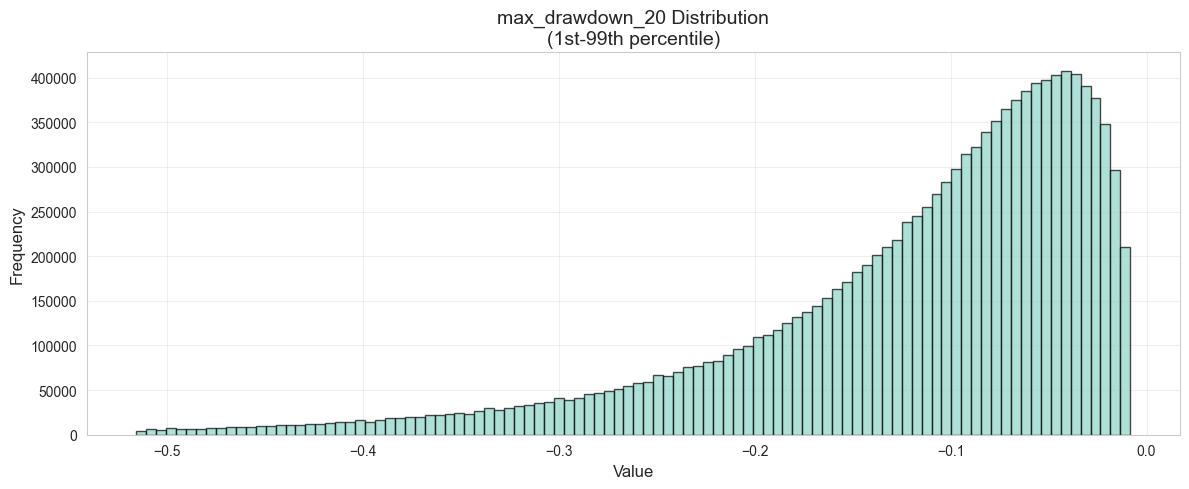

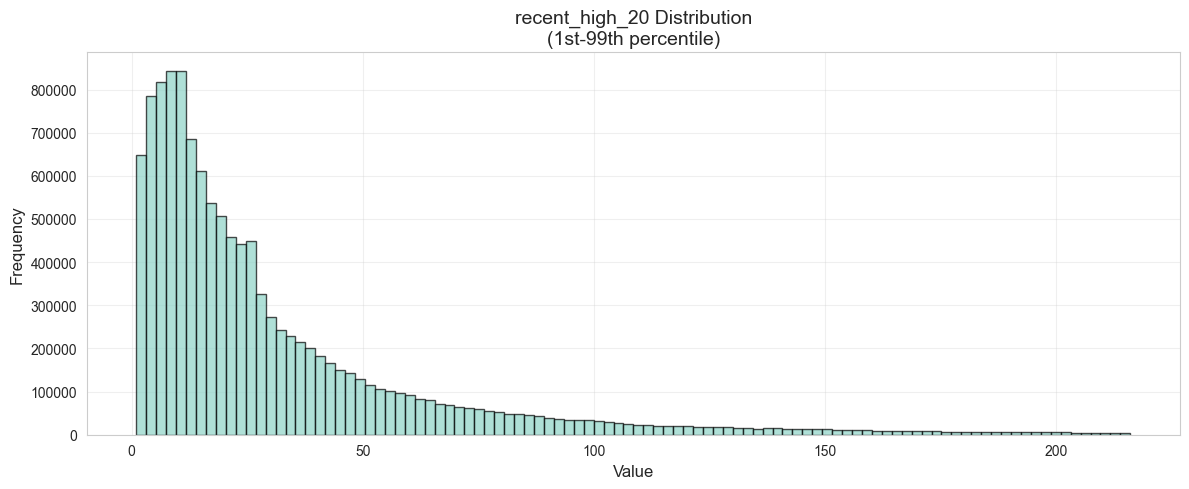

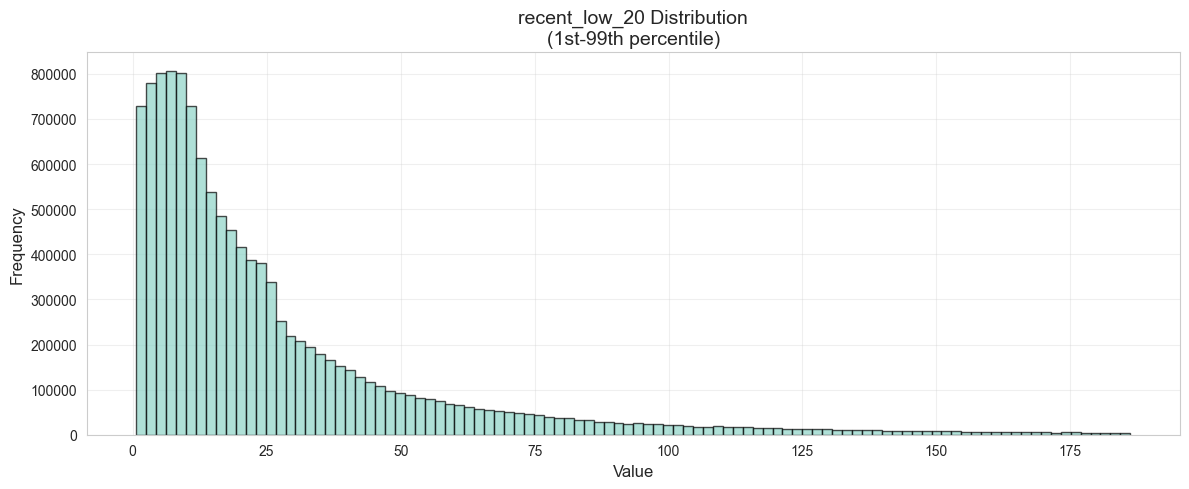

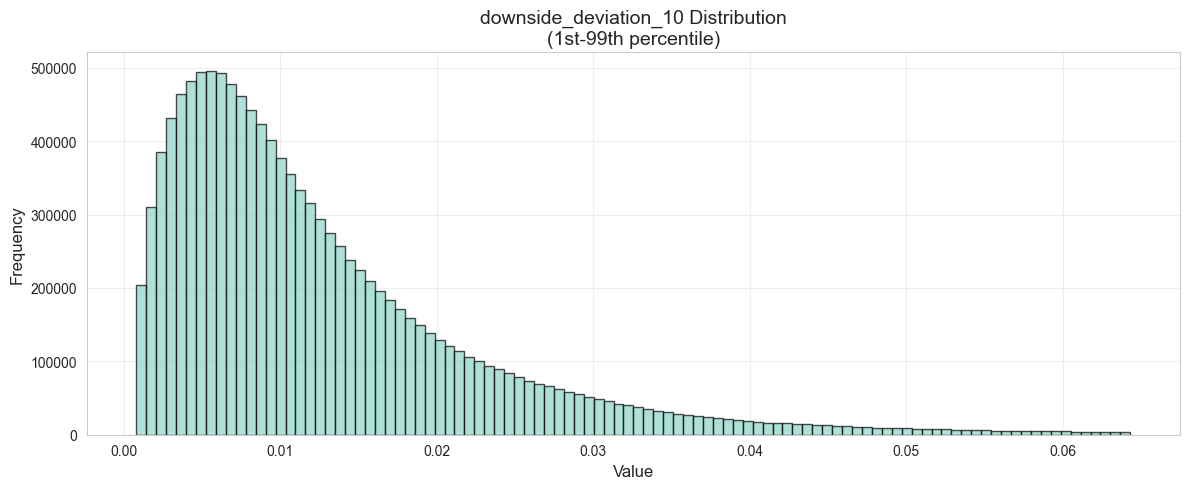

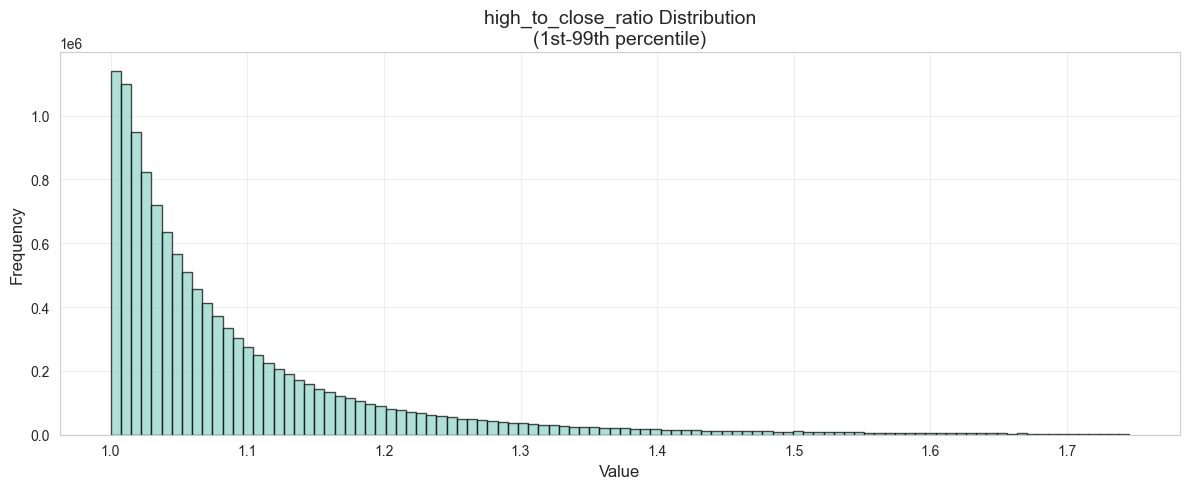

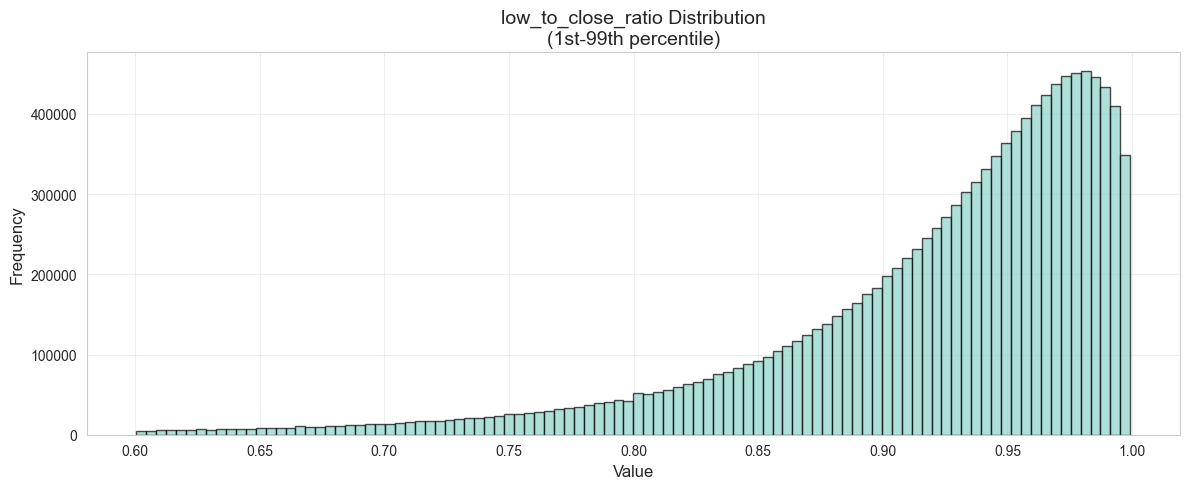

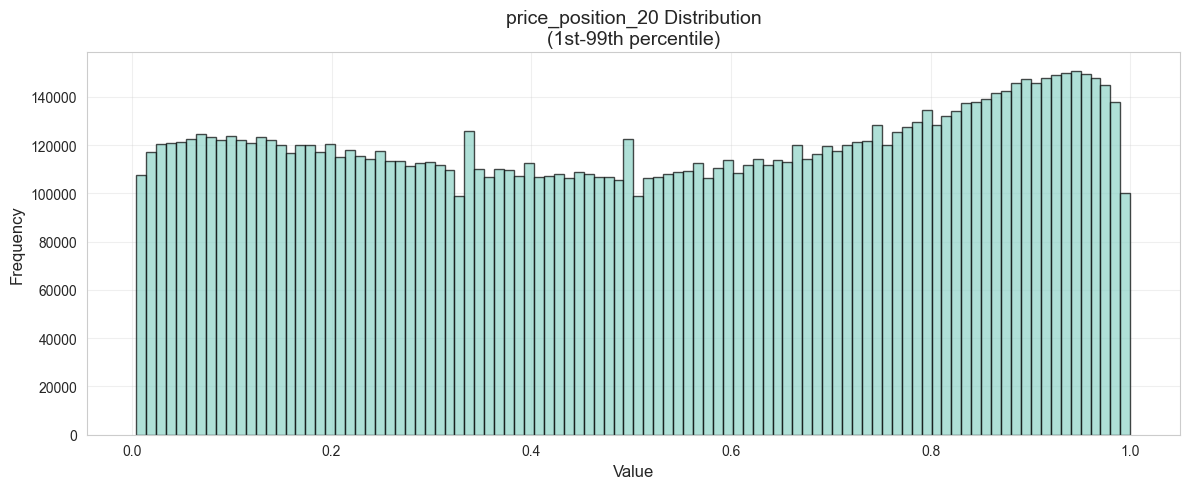

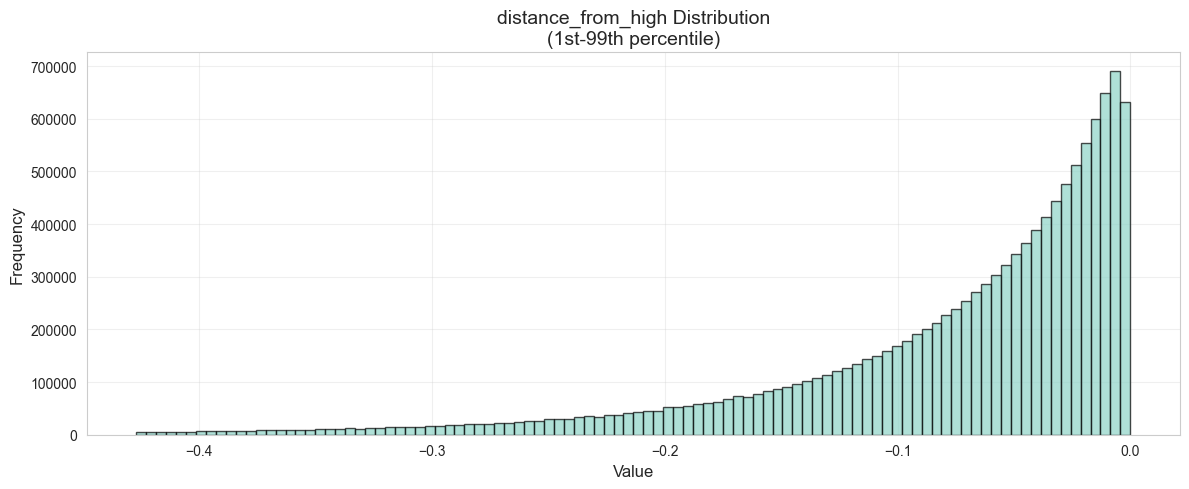

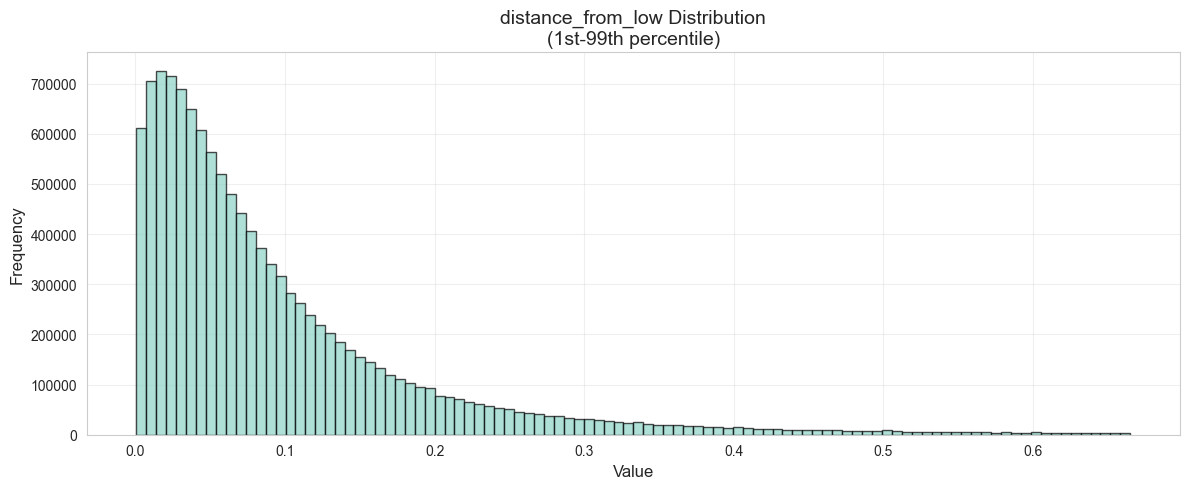

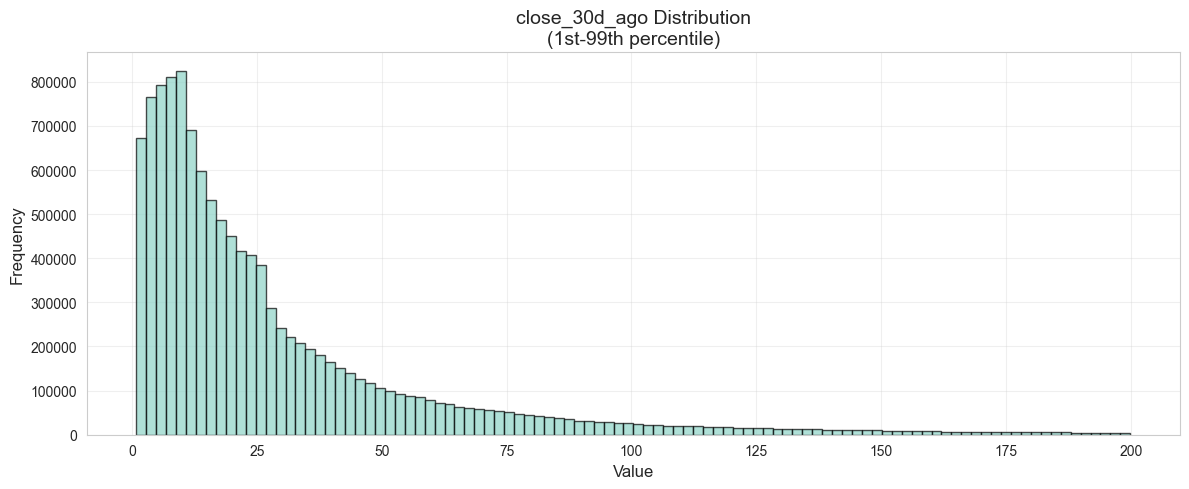

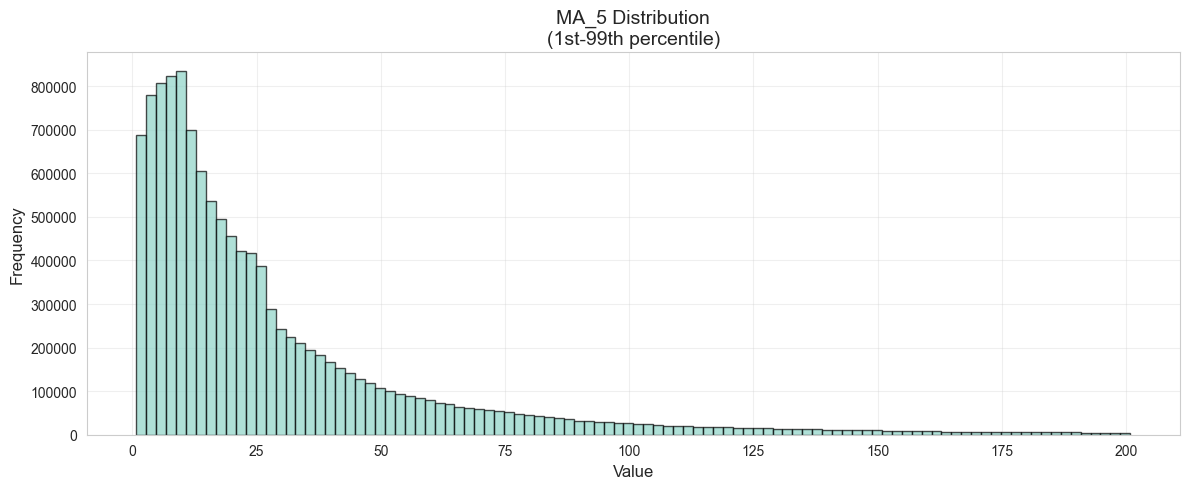

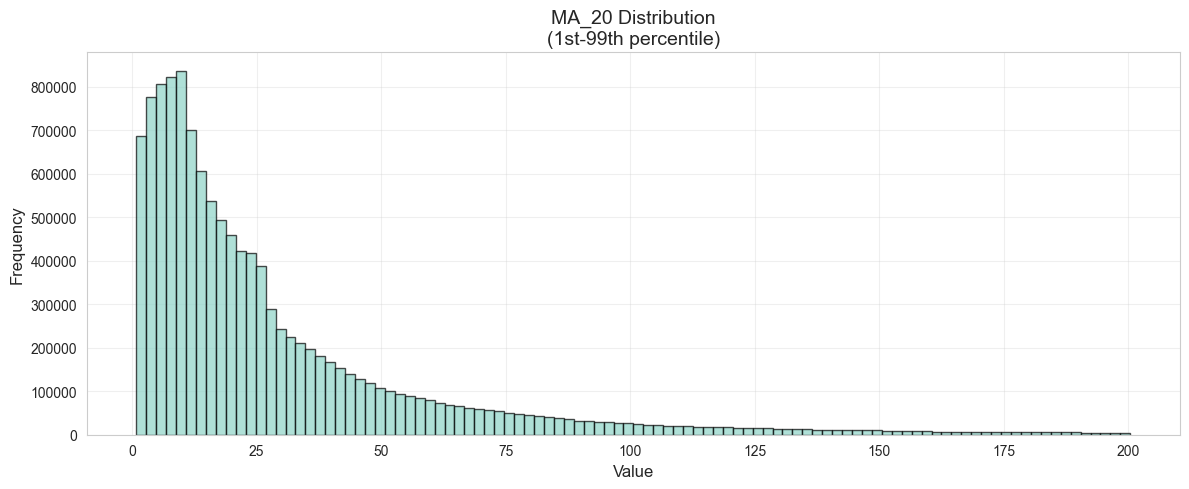

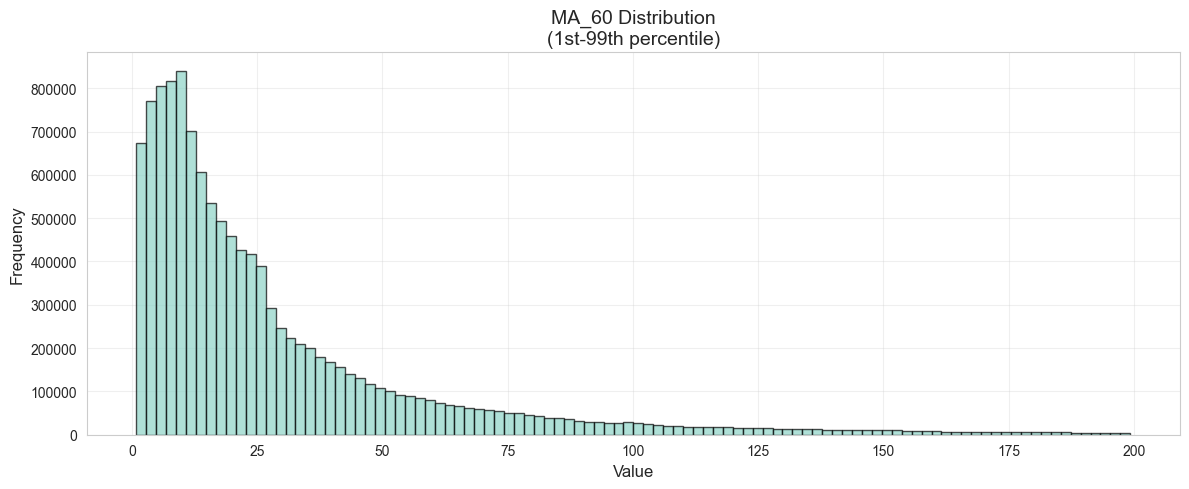

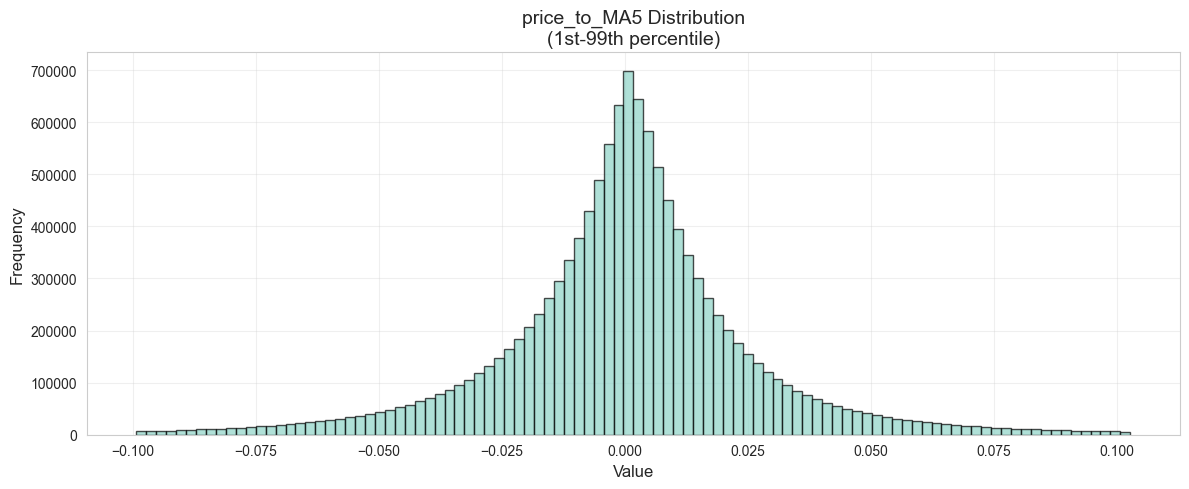

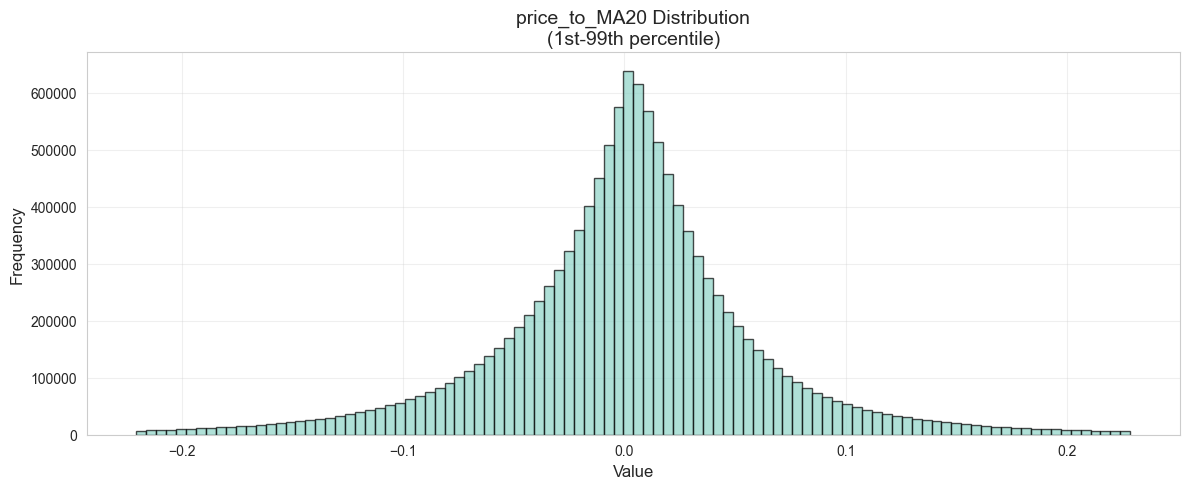

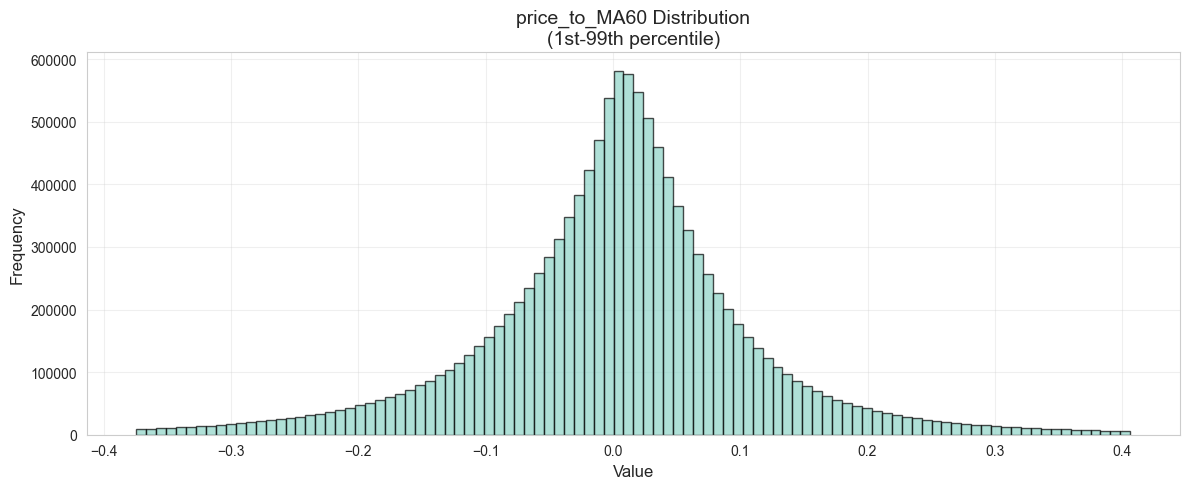

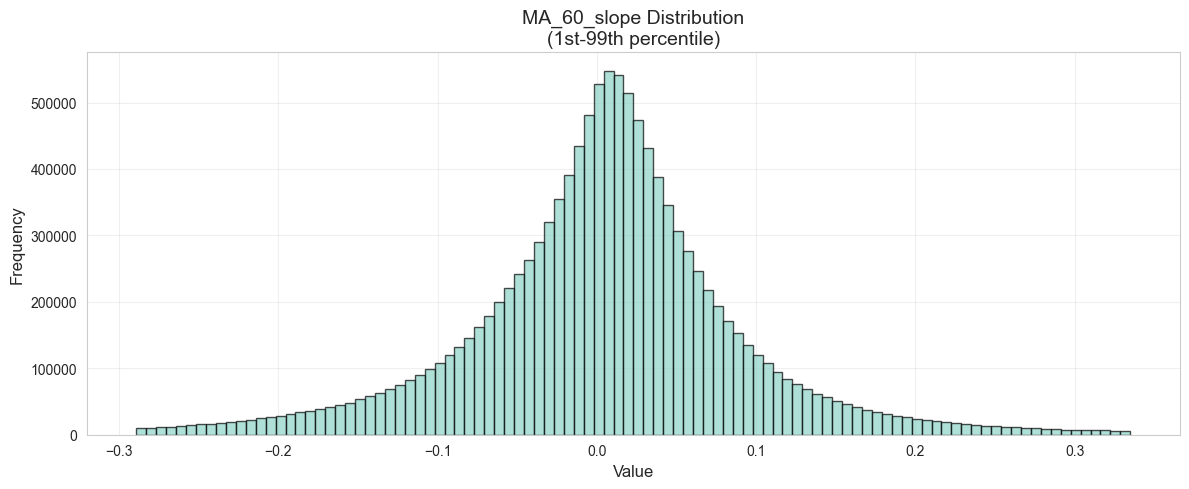

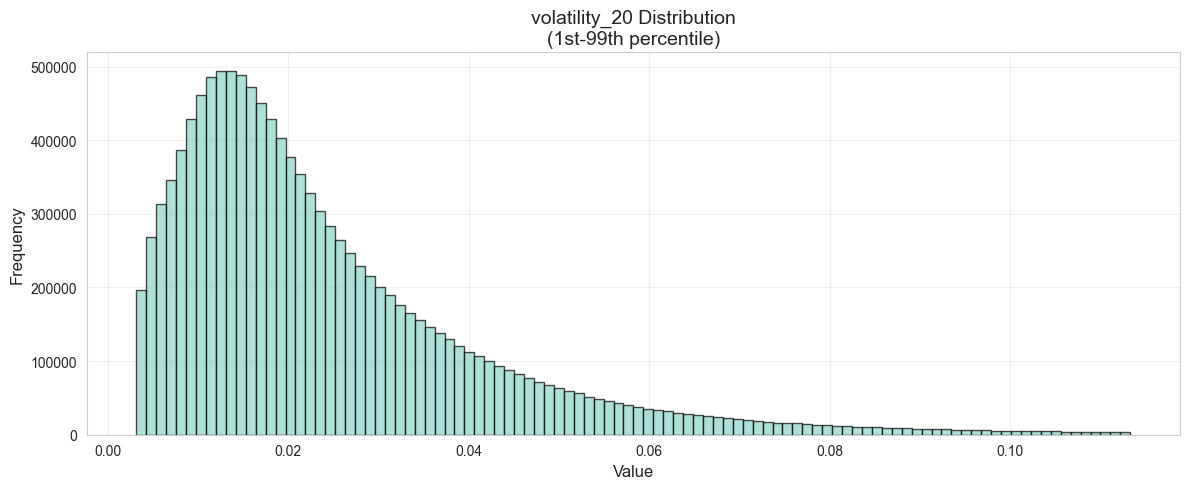

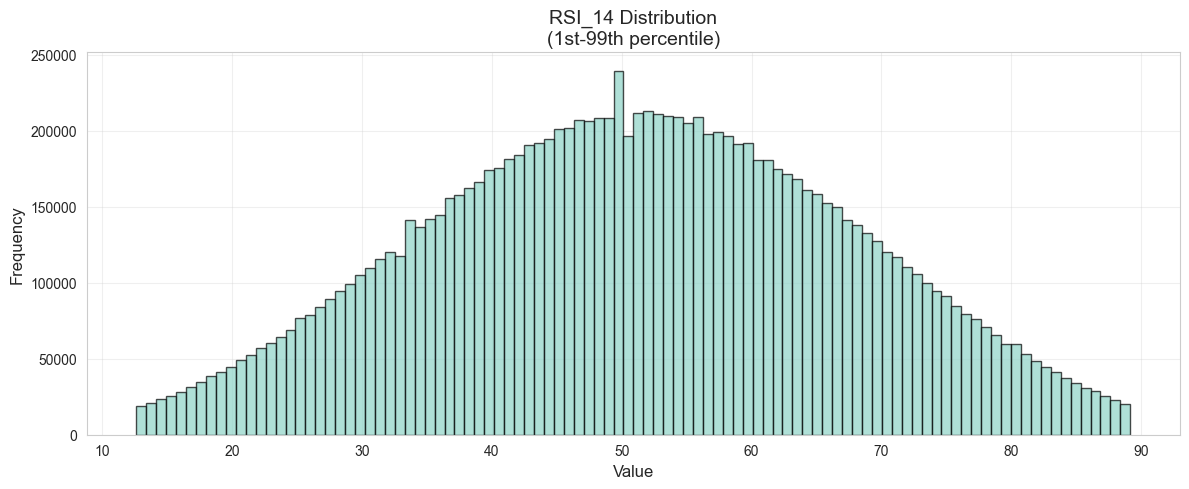

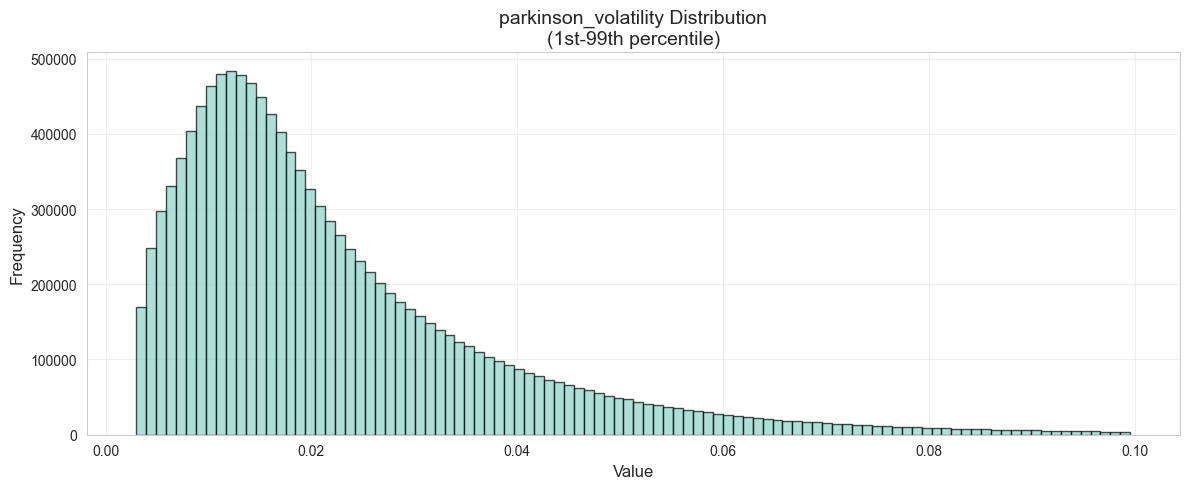

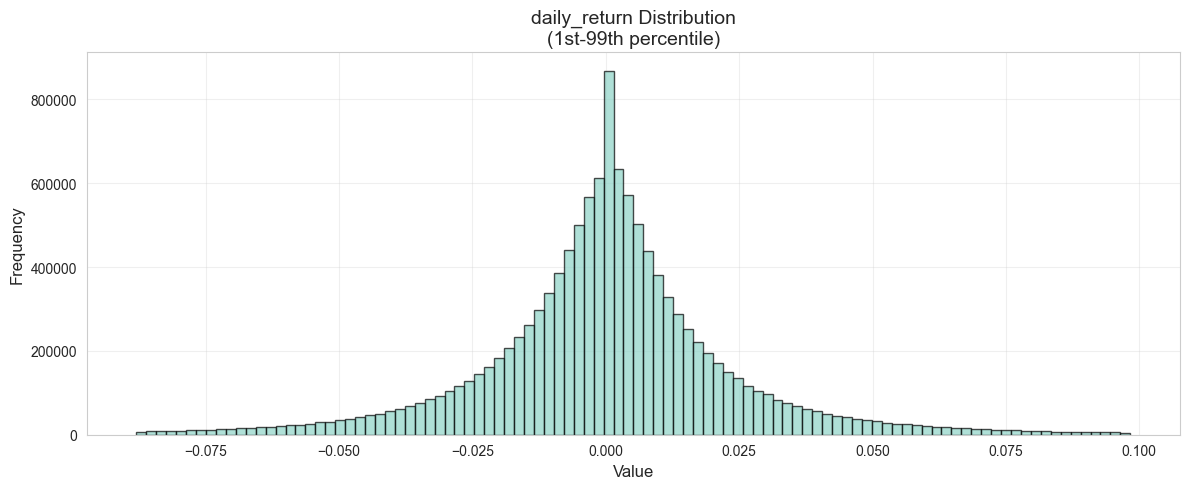

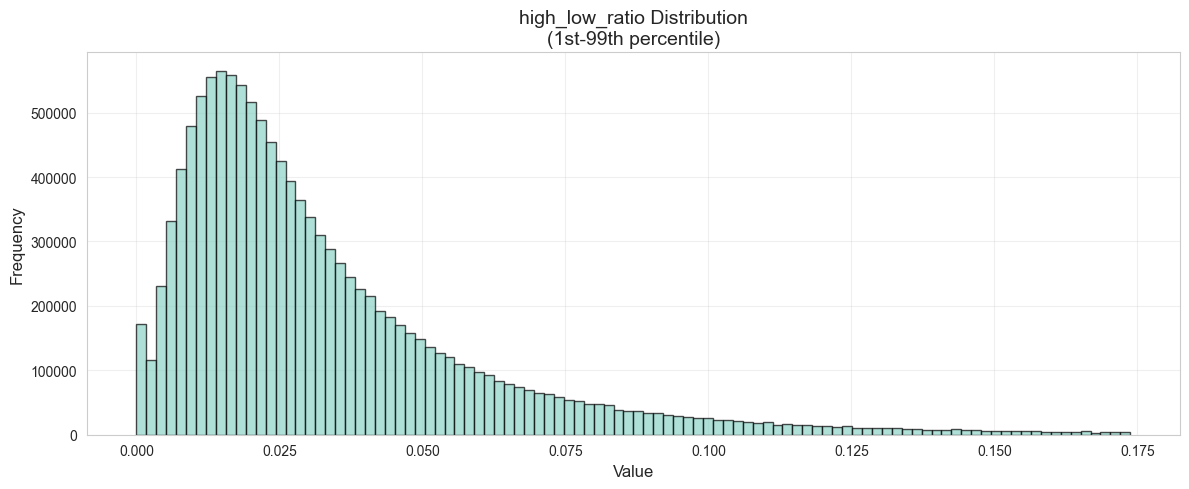

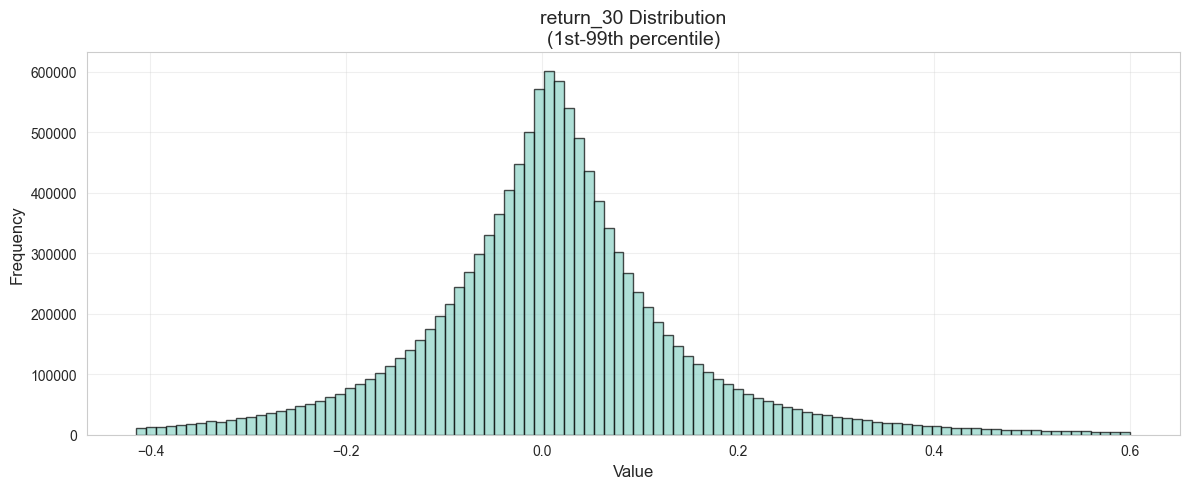

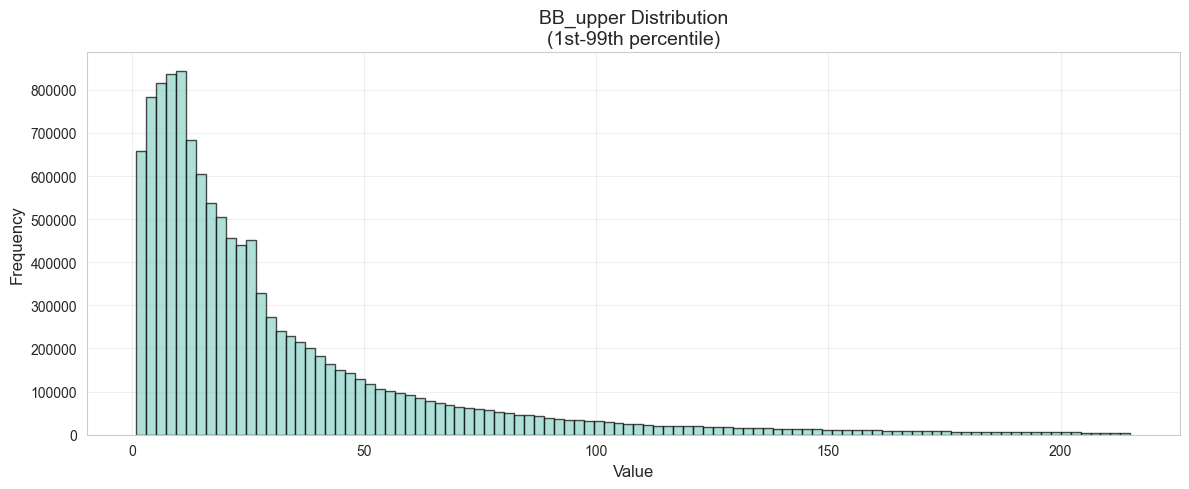

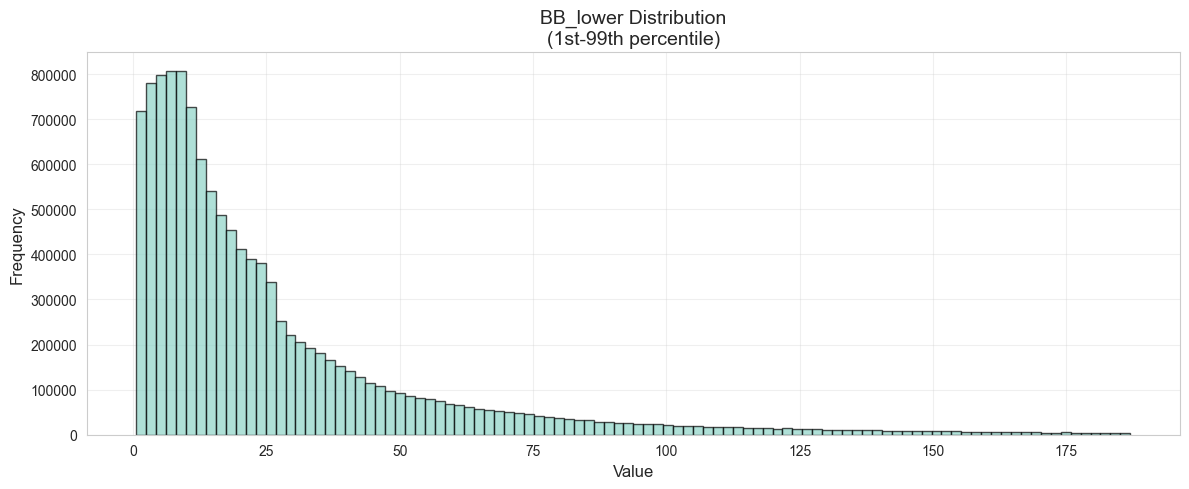

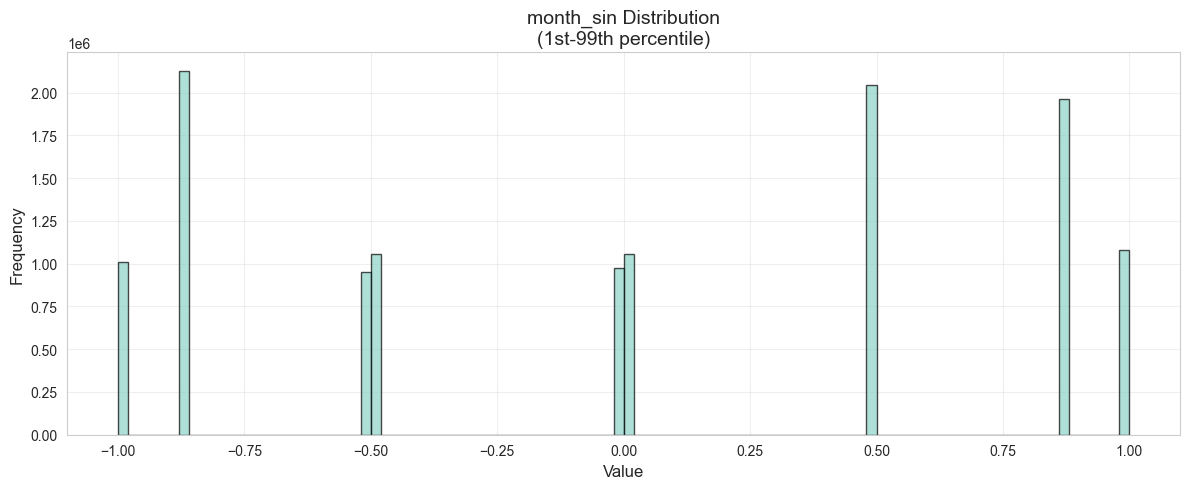

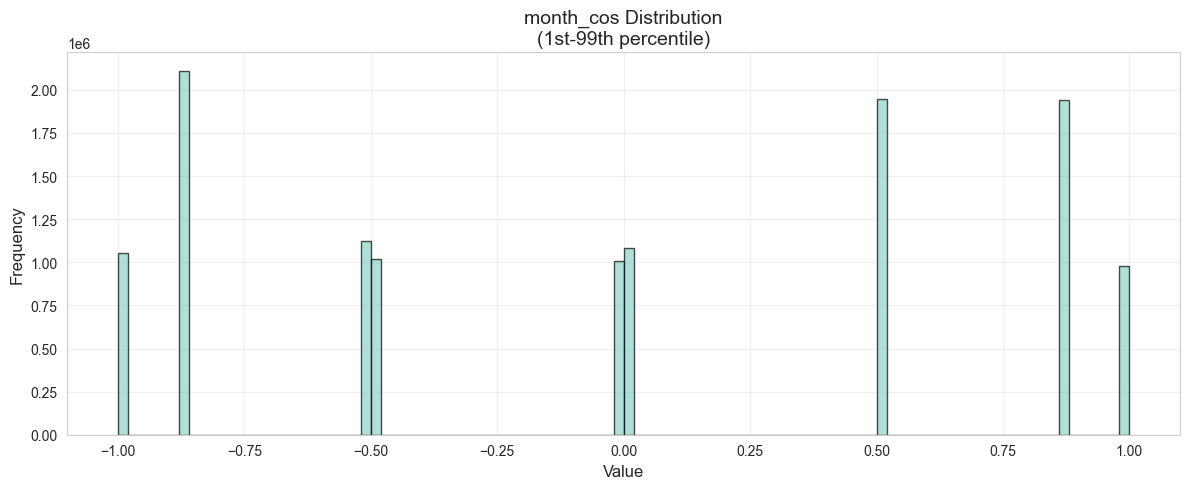

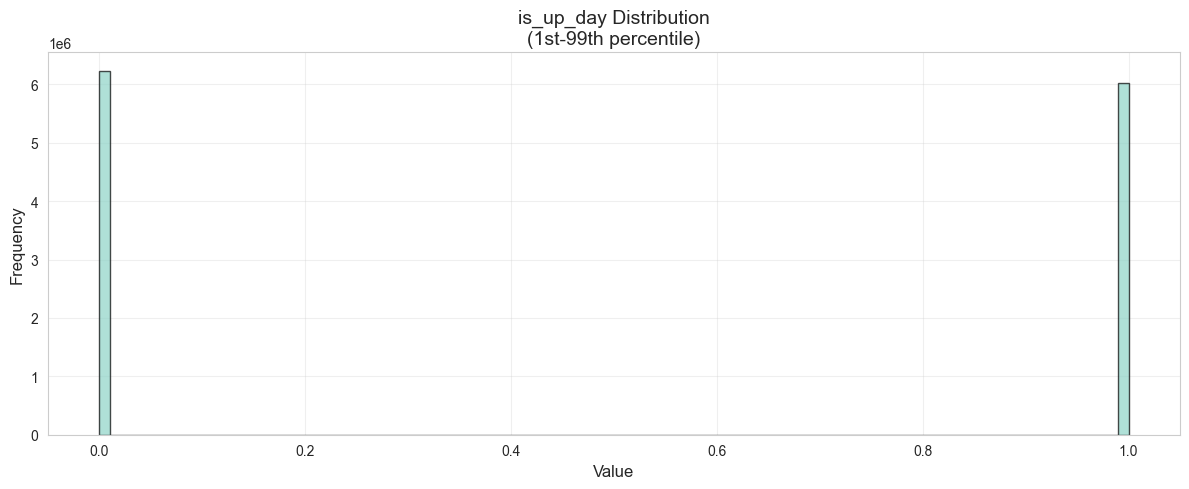

In [62]:

# ============================================================================
# SECTION 3: DATA QUALITY ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("[3] DATA QUALITY ANALYSIS")
print("="*80)

feature_columns = [
    # Critical (4)
    'max_drawdown_20',
    'recent_high_20',
    'recent_low_20',
    'downside_deviation_10',

    # Normalized Price (3) - NEW
    'high_to_close_ratio',
    'low_to_close_ratio',
    'price_position_20',

    # Price Position (3)
    'distance_from_high',
    'distance_from_low',
    'close_30d_ago',

    # Moving Averages (3)
    'MA_5',
    'MA_20',
    'MA_60',

    # MA-Based (4)
    'price_to_MA5',
    'price_to_MA20',
    'price_to_MA60',
    'MA_60_slope',

    # Volatility (3)
    'volatility_20',
    'RSI_14',
    'parkinson_volatility',

    # Price Features (3)
    'daily_return',
    'high_low_ratio',
    'return_30',

    # Bollinger Bands (2)
    'BB_upper',
    'BB_lower',

    # Temporal (2) - NEW
    'month_sin',
    'month_cos',

    # Advanced (1)
    'is_up_day',
]

# Check missing values
print("\nMissing values in engineered features:")
missing_stats = df_features[feature_columns].isnull().sum()
missing_pct = (missing_stats / len(df_features) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing_Count': missing_stats,
    'Missing_Percentage': missing_pct
})
print(missing_df)

# Basic statistics
print("\n" + "="*80)
print("FEATURE STATISTICS")
print("="*80)
print(df_features[feature_columns].describe())

IMAGE_DIR = "Images2"
os.makedirs(IMAGE_DIR, exist_ok=True)

# Visualization: Distribution of features
for feature in feature_columns:
    data = df_features[feature].dropna()

    # Remove extreme outliers for better visualization (keep 1st-99th percentile)
    q1, q99 = data.quantile([0.01, 0.99])
    data_filtered = data[(data >= q1) & (data <= q99)]

    plt.figure(figsize=(12, 5))  # wider figure
    plt.hist(data_filtered, bins=100, edgecolor='black', alpha=0.7)
    plt.title(f'{feature} Distribution\n(1st-99th percentile)', fontsize=14)
    plt.xlabel('Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(
        os.path.join(IMAGE_DIR, f'feature_{feature}.png'),
        dpi=300,
        bbox_inches='tight'
    )

    plt.show()


[4] AUTOCORRELATION ANALYSIS
Analyzing how each feature correlates with its past values
This helps determine optimal sequence length for RNN

Analyzing autocorrelation: max_drawdown_20


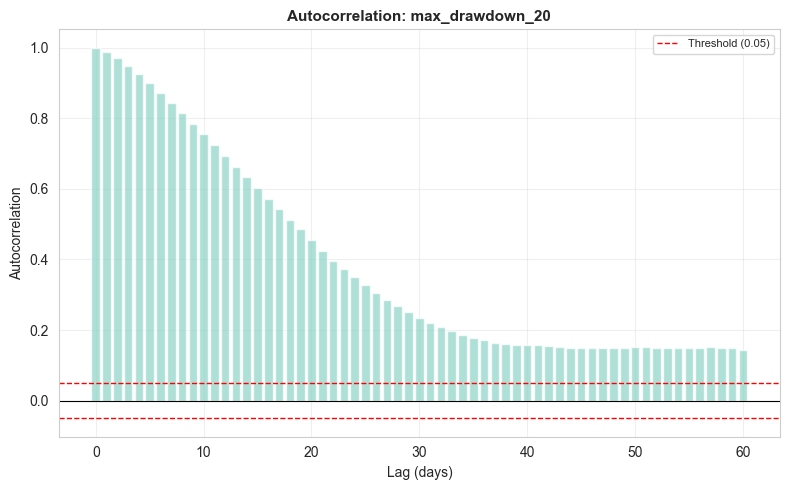

  Optimal lag: 60 days (autocorr = 0.1425)

Analyzing autocorrelation: recent_high_20


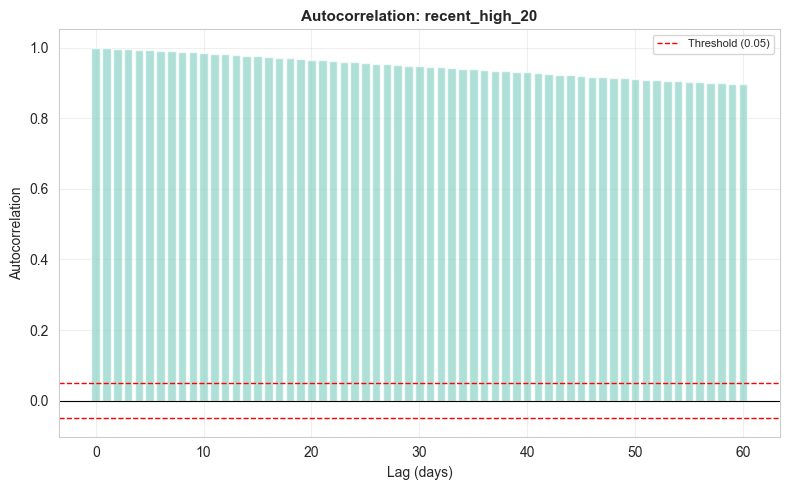

  Optimal lag: 60 days (autocorr = 0.8962)

Analyzing autocorrelation: recent_low_20


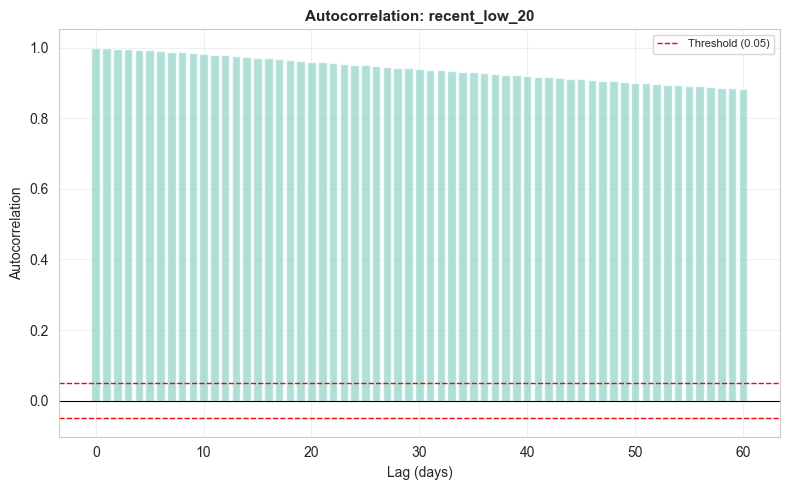

  Optimal lag: 60 days (autocorr = 0.8837)

Analyzing autocorrelation: downside_deviation_10


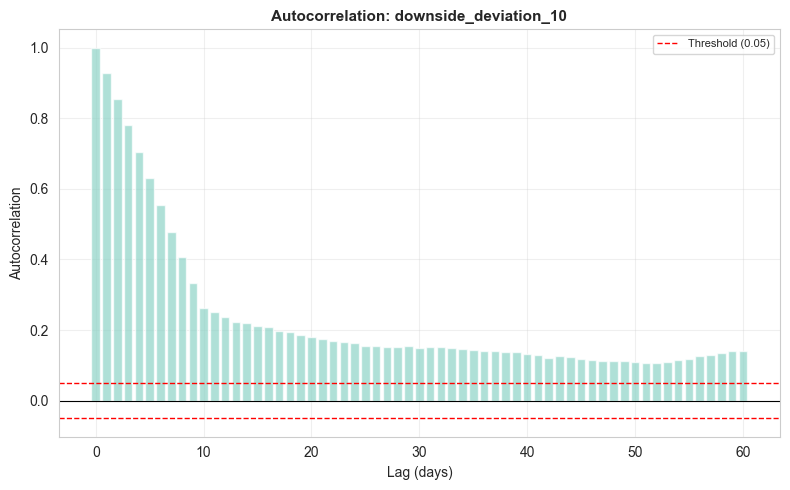

  Optimal lag: 60 days (autocorr = 0.1416)

Analyzing autocorrelation: high_to_close_ratio


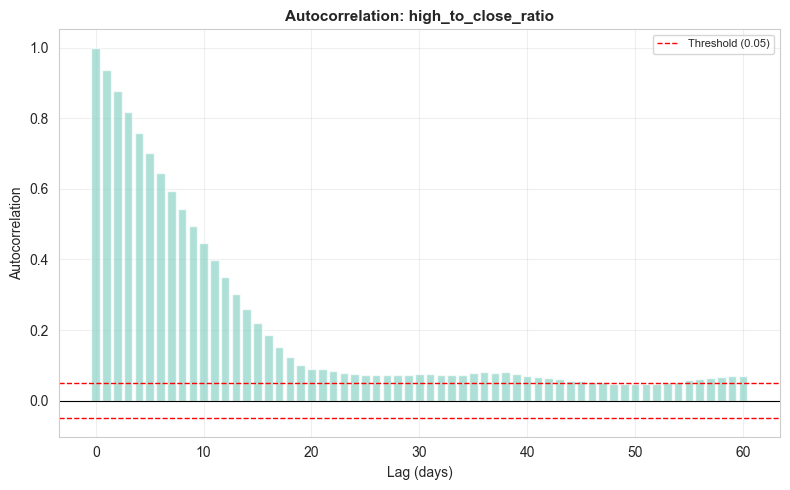

  Optimal lag: 60 days (autocorr = 0.0705)

Analyzing autocorrelation: low_to_close_ratio


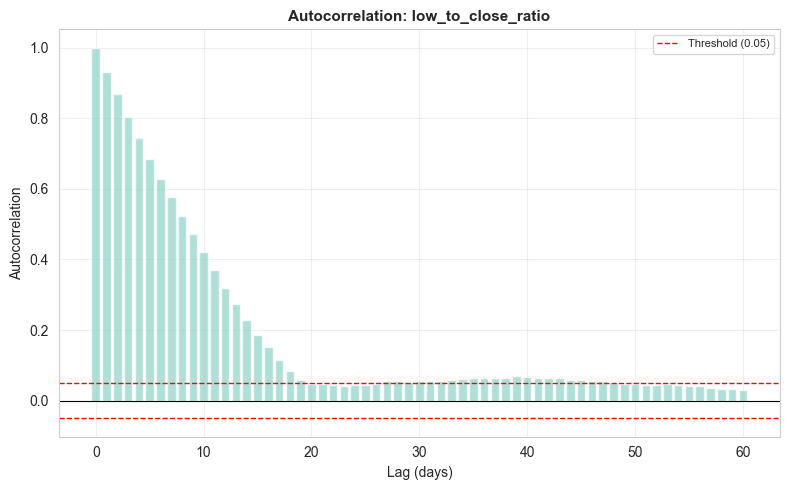

  Optimal lag: 47 days (autocorr = 0.0548)

Analyzing autocorrelation: price_position_20


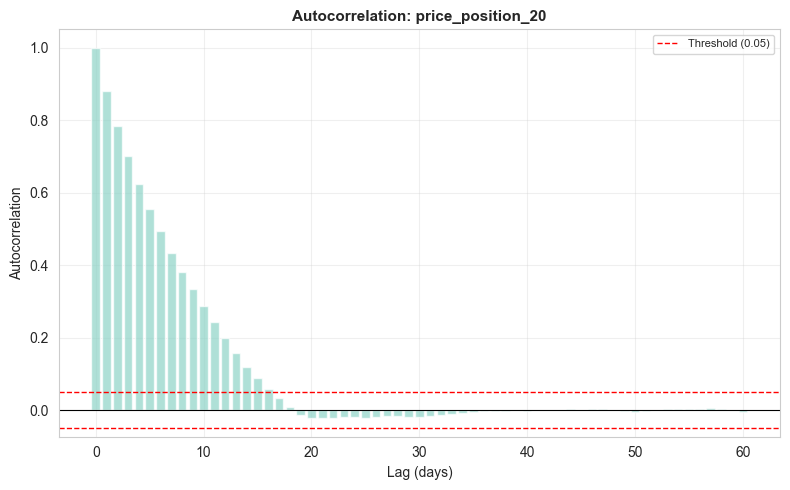

  Optimal lag: 16 days (autocorr = 0.0597)

Analyzing autocorrelation: distance_from_high


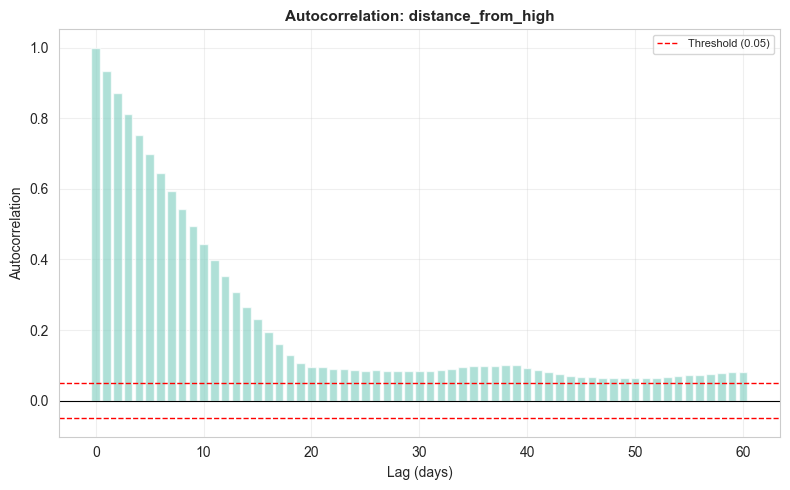

  Optimal lag: 60 days (autocorr = 0.0801)

Analyzing autocorrelation: distance_from_low


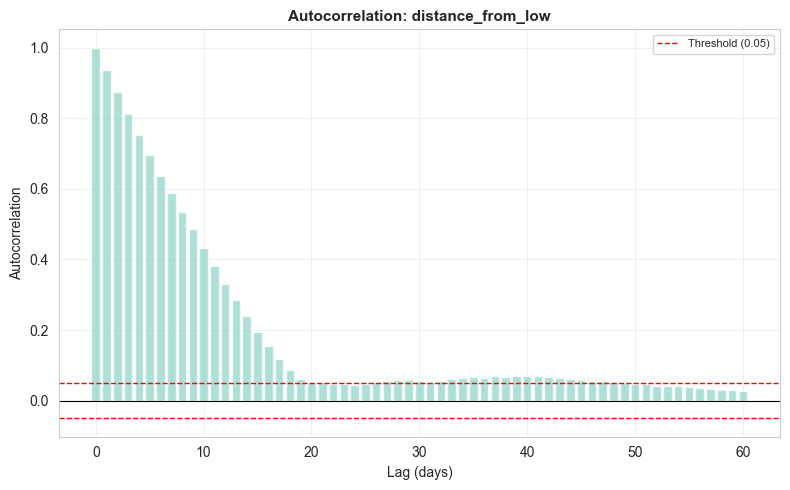

  Optimal lag: 48 days (autocorr = 0.0530)

Analyzing autocorrelation: close_30d_ago


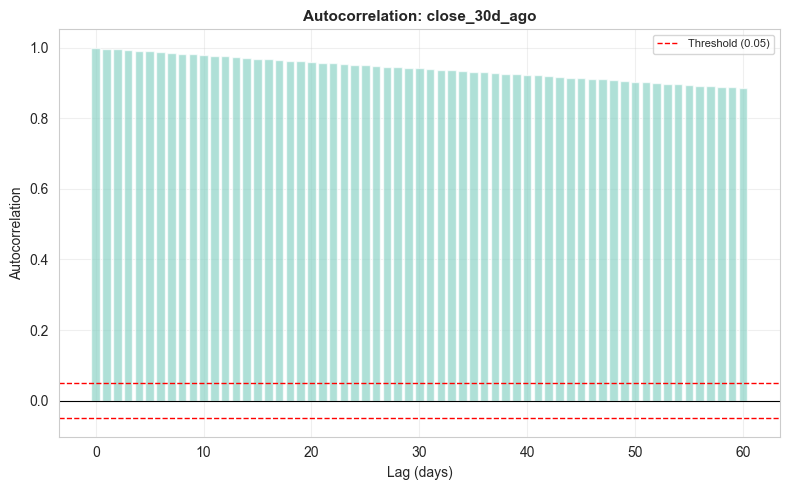

  Optimal lag: 60 days (autocorr = 0.8859)

Analyzing autocorrelation: MA_5


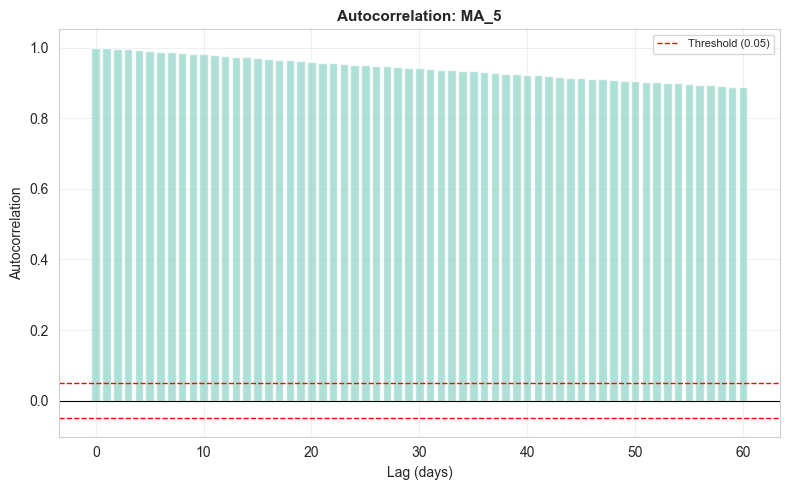

  Optimal lag: 60 days (autocorr = 0.8885)

Analyzing autocorrelation: MA_20


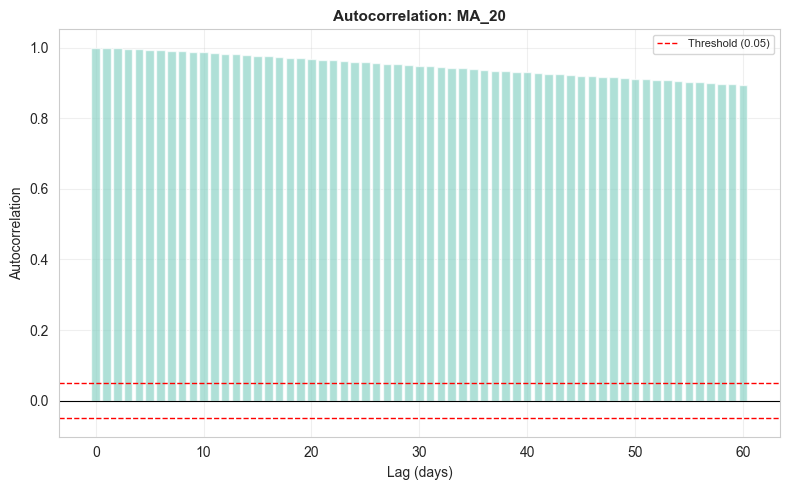

  Optimal lag: 60 days (autocorr = 0.8955)

Analyzing autocorrelation: MA_60


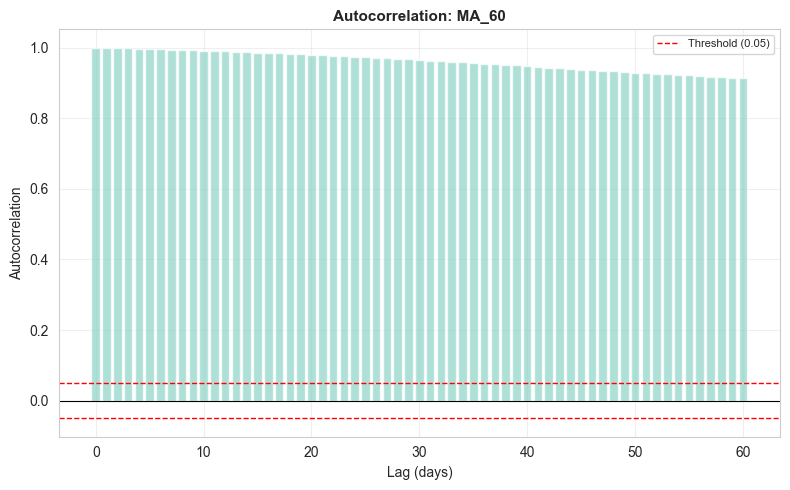

  Optimal lag: 60 days (autocorr = 0.9135)

Analyzing autocorrelation: price_to_MA5


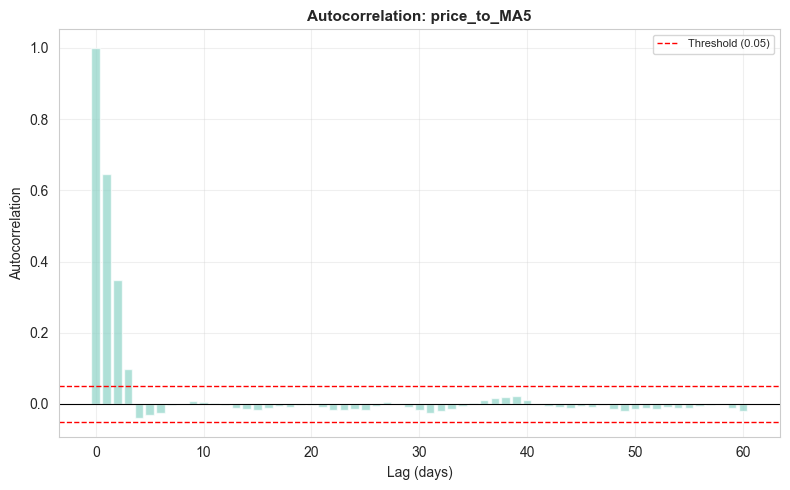

  Optimal lag: 3 days (autocorr = 0.0993)

Analyzing autocorrelation: price_to_MA20


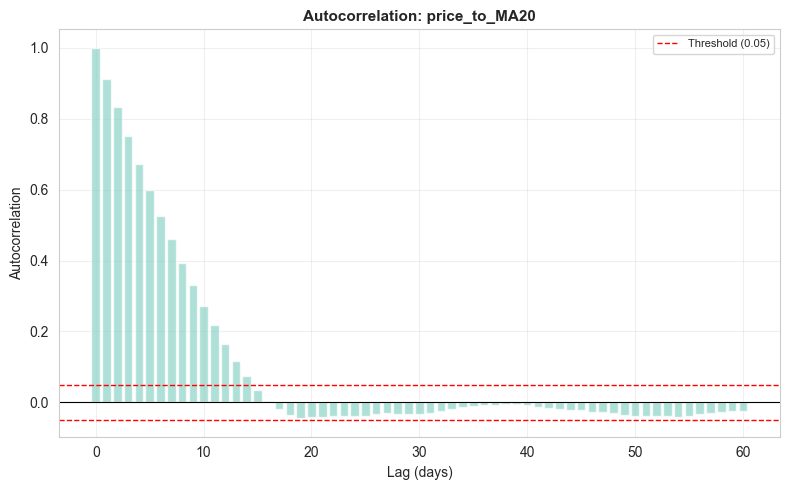

  Optimal lag: 14 days (autocorr = 0.0736)

Analyzing autocorrelation: price_to_MA60


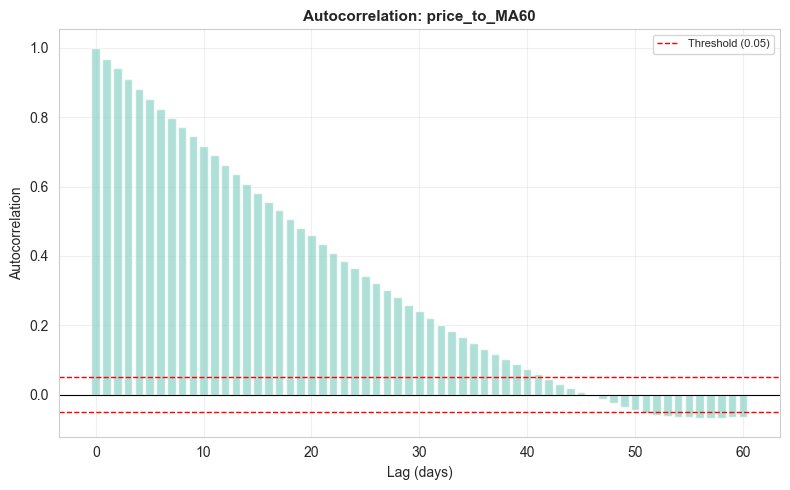

  Optimal lag: 60 days (autocorr = -0.0632)

Analyzing autocorrelation: MA_60_slope


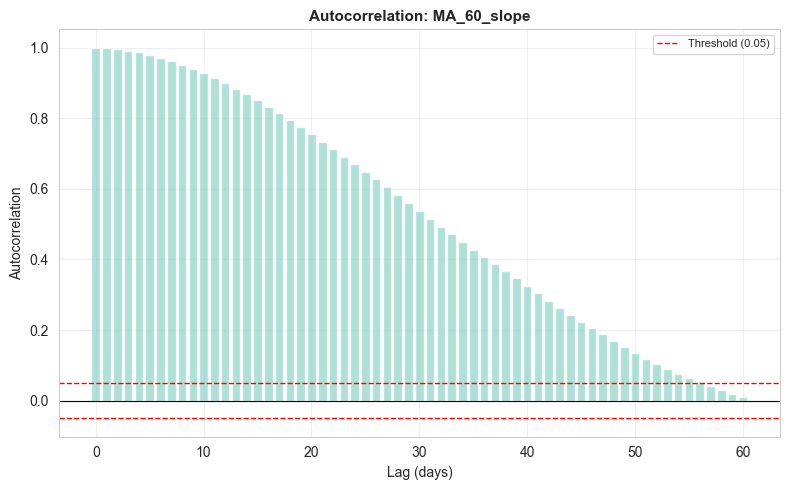

  Optimal lag: 56 days (autocorr = 0.0530)

Analyzing autocorrelation: volatility_20


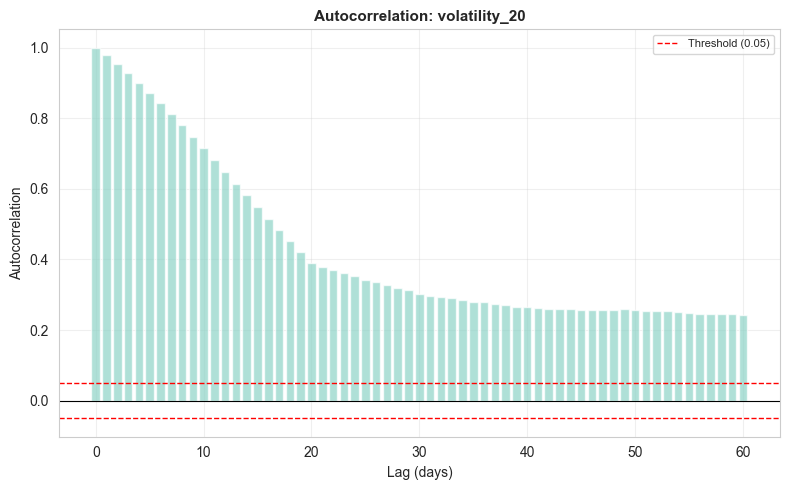

  Optimal lag: 60 days (autocorr = 0.2419)

Analyzing autocorrelation: RSI_14


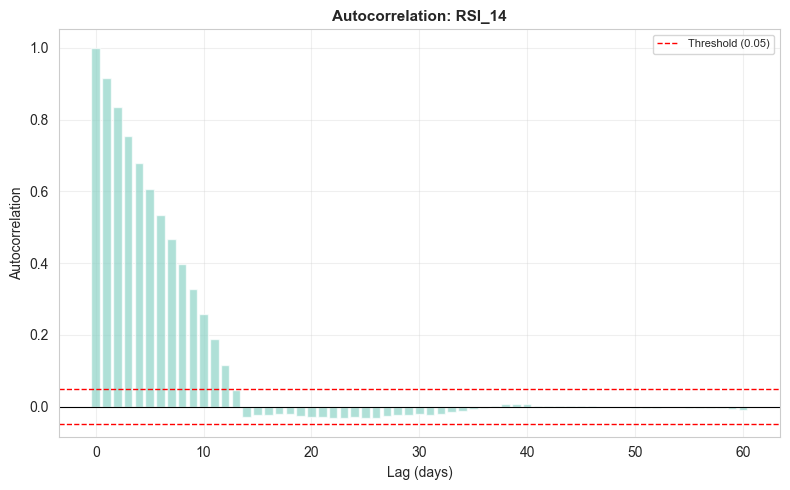

  Optimal lag: 12 days (autocorr = 0.1151)

Analyzing autocorrelation: parkinson_volatility


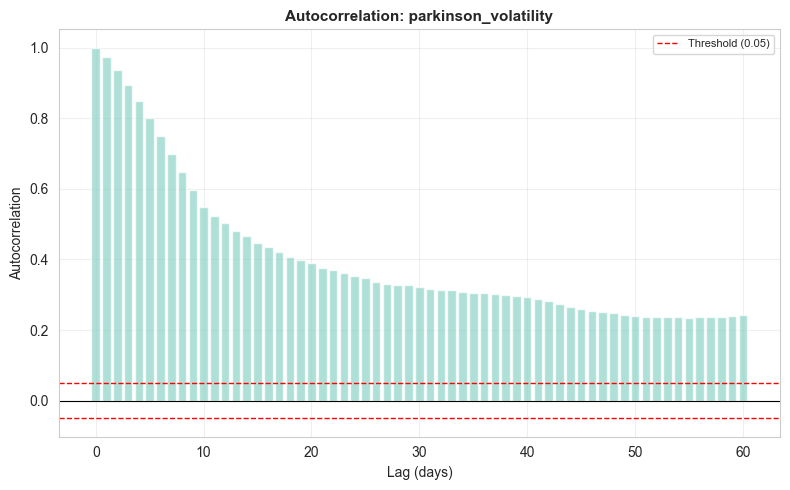

  Optimal lag: 60 days (autocorr = 0.2423)

Analyzing autocorrelation: daily_return


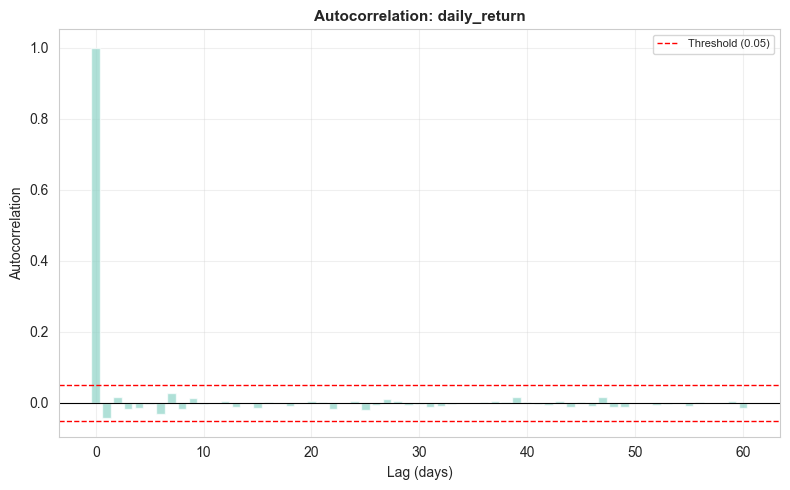

  low autocorrelation (independent)

Analyzing autocorrelation: high_low_ratio


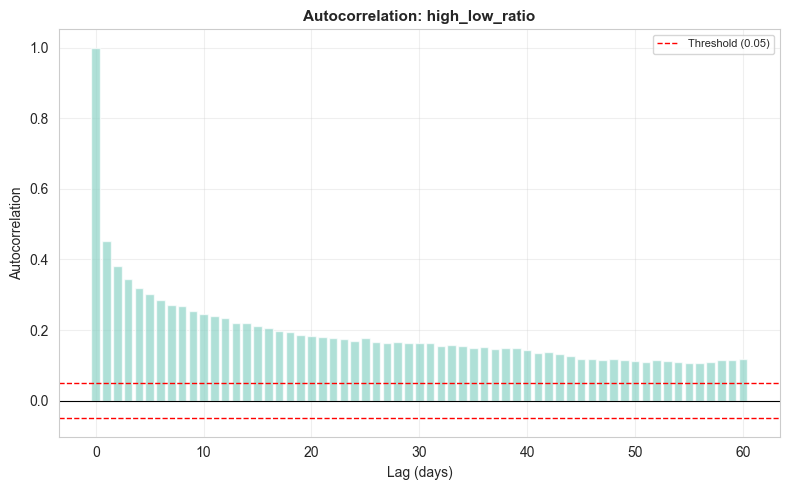

  Optimal lag: 60 days (autocorr = 0.1166)

Analyzing autocorrelation: return_30


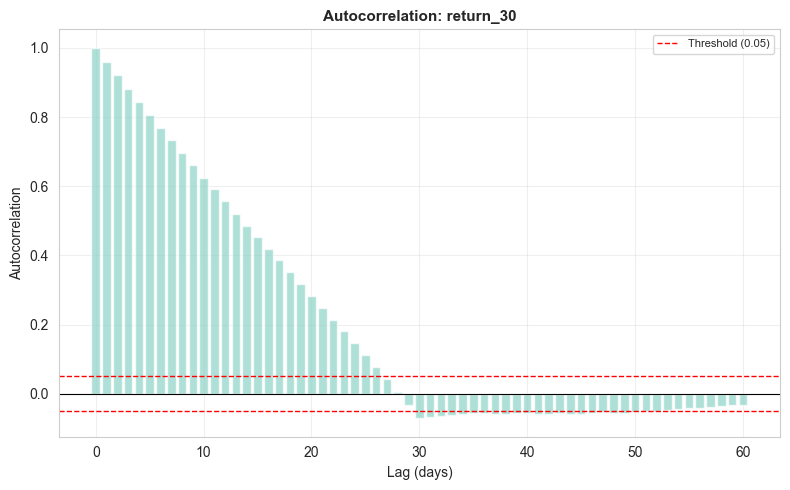

  Optimal lag: 52 days (autocorr = -0.0501)

Analyzing autocorrelation: BB_upper


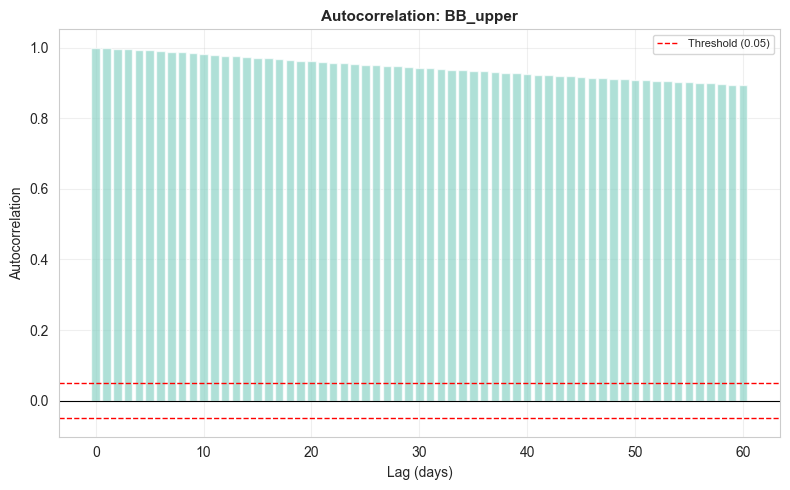

  Optimal lag: 60 days (autocorr = 0.8942)

Analyzing autocorrelation: BB_lower


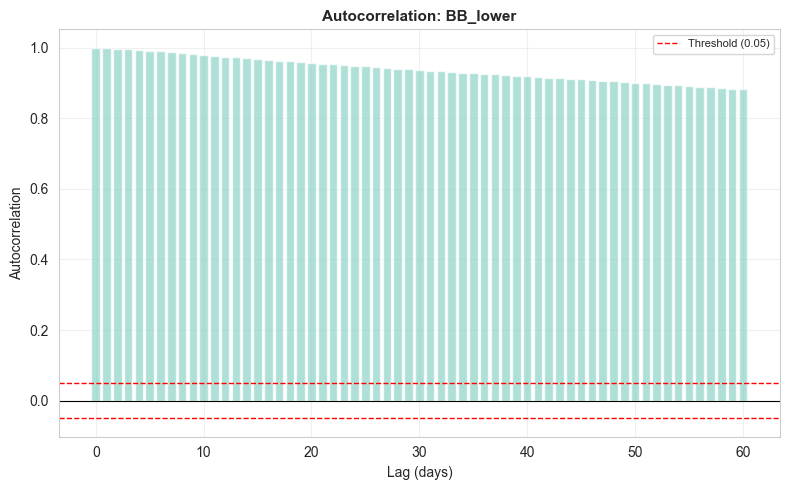

  Optimal lag: 60 days (autocorr = 0.8822)

Analyzing autocorrelation: month_sin


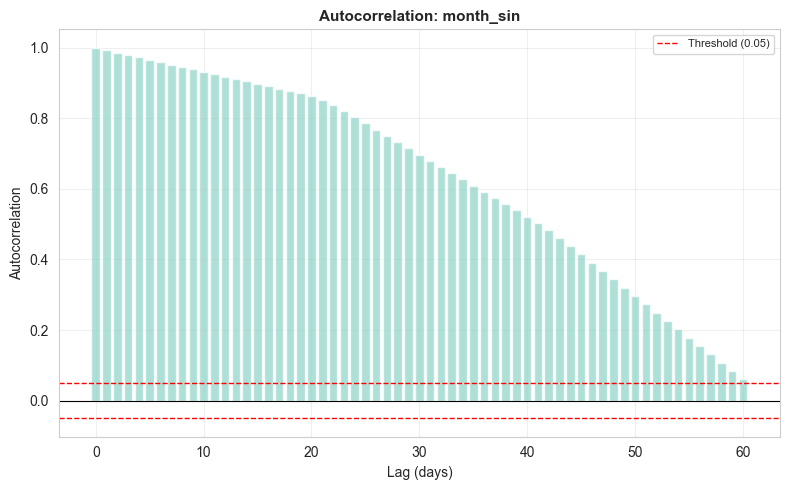

  Optimal lag: 60 days (autocorr = 0.0605)

Analyzing autocorrelation: month_cos


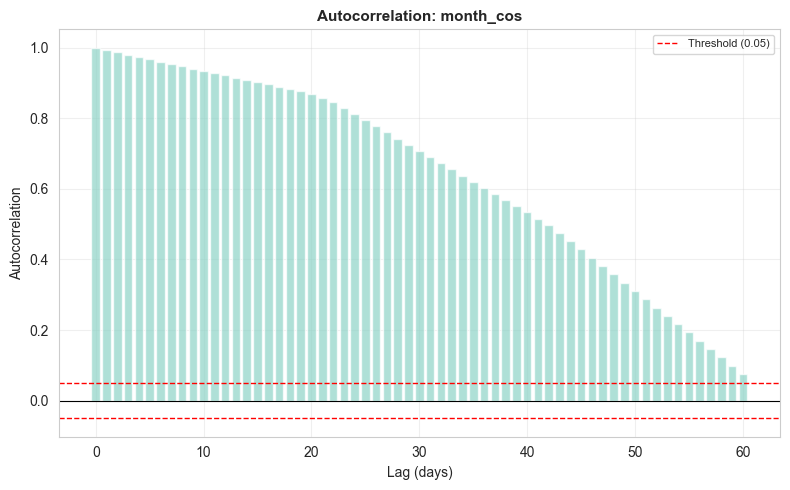

  Optimal lag: 60 days (autocorr = 0.0755)

Analyzing autocorrelation: is_up_day


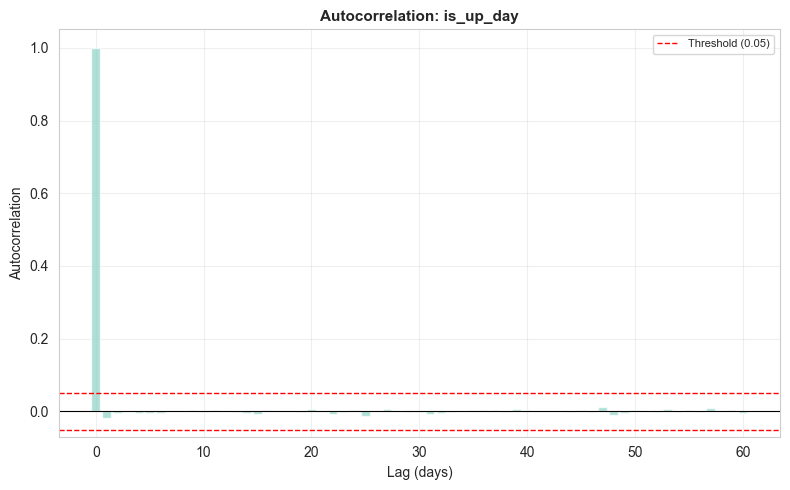

  low autocorrelation (independent)

AUTOCORRELATION DECAY SUMMARY
              Feature    Lag_10    Lag_20    Lag_30  Decay_Point
      max_drawdown_20  0.756070  0.455093  0.234903           60
       recent_high_20  0.985251  0.966381  0.947971           60
        recent_low_20  0.983002  0.961034  0.940062           60
downside_deviation_10  0.262746  0.180595  0.150433           60
  high_to_close_ratio  0.446805  0.088858  0.074150           48
   low_to_close_ratio  0.421841  0.046649  0.054401           20
    price_position_20  0.286623 -0.021317 -0.019491           17
   distance_from_high  0.444241  0.096579  0.083687           60
    distance_from_low  0.432048  0.050872  0.054370           22
        close_30d_ago  0.979908  0.959941  0.941771           60
                 MA_5  0.981370  0.960469  0.941821           60
                MA_20  0.987759  0.968557  0.949256           60
                MA_60  0.992087  0.980711  0.965394           60
         price_to_MA5  

In [63]:

# ============================================================================
# SECTION 4: AUTOCORRELATION ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("[4] AUTOCORRELATION ANALYSIS")
print("="*80)
print("Analyzing how each feature correlates with its past values")
print("This helps determine optimal sequence length for RNN")

# ----------------------------------------------------------------------------
# CONFIGURATION
# ----------------------------------------------------------------------------
NUM_TICKERS_TO_USE = 200    # <<< CHANGE THIS TO CONTROL HOW MANY TICKERS ARE USED
max_lags = 60             # Analyze up to 60 days lag
threshold = 0.05

# ----------------------------------------------------------------------------
# PREPARE DATA (KEEP TEMPORAL ORDER)
# ----------------------------------------------------------------------------
df_features = df_features.sort_values(['ticker', 'date'])

selected_tickers = (
    df_features['ticker']
    .dropna()
    .unique()[:NUM_TICKERS_TO_USE]
)

df_sample = (
    df_features
    .loc[df_features['ticker'].isin(selected_tickers)]
    .dropna(subset=feature_columns)
)

# ----------------------------------------------------------------------------
# AUTOCORRELATION COMPUTATION
# ----------------------------------------------------------------------------
autocorr_results = {}
# feature_columns = [
#     'daily_return', 'high_low_ratio', 'return_30',
#     #'MA_5', 'MA_10', 'MA_30', 'STD_10',
#     'log_volume', 'volume_ratio'
#     #, 'dividend_yield'
# ]

for feature in feature_columns:
    print(f"\nAnalyzing autocorrelation: {feature}")

    per_ticker_acfs = []

    for ticker, g in df_sample.groupby('ticker'):
        data = g[feature].dropna()

        if len(data) <= max_lags:
            continue

        autocorr_values = acf(data, nlags=max_lags, fft=True)
        per_ticker_acfs.append(autocorr_values)

    if len(per_ticker_acfs) == 0:
        print("  Not enough data")
        continue

    # Aggregate across tickers (median preserves typical temporal behavior)
    autocorr_values = np.median(per_ticker_acfs, axis=0)
    autocorr_results[feature] = autocorr_values

    # ----------------------------------------------------------------------------
    # PLOT (single plot per feature)
    # ----------------------------------------------------------------------------
    plt.figure(figsize=(8, 5))
    lags = np.arange(len(autocorr_values))

    plt.bar(lags, autocorr_values, width=0.8, alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    plt.axhline(y=threshold, color='red', linestyle='--', linewidth=1, label='Threshold (0.05)')
    plt.axhline(y=-threshold, color='red', linestyle='--', linewidth=1)

    plt.title(f'Autocorrelation: {feature}', fontsize=11, fontweight='bold')
    plt.xlabel('Lag (days)')
    plt.ylabel('Autocorrelation')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGE_DIR, f'autocorrelation_{feature}.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # ----------------------------------------------------------------------------
    # FIND OPTIMAL LAG
    # ----------------------------------------------------------------------------
    significant_lags = np.where(np.abs(autocorr_values) > threshold)[0]

    if len(significant_lags) > 1:
        optimal_lag = significant_lags[-1]
        print(f"  Optimal lag: {optimal_lag} days (autocorr = {autocorr_values[optimal_lag]:.4f})")
    else:
        print(f"  low autocorrelation (independent)")

# ----------------------------------------------------------------------------
# SUMMARY TABLE OF AUTOCORRELATION DECAY
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("AUTOCORRELATION DECAY SUMMARY")
print("="*80)

decay_summary = []

for feature, autocorr_vals in autocorr_results.items():
    below_threshold = np.where(np.abs(autocorr_vals[1:]) < threshold)[0]

    if len(below_threshold) > 0:
        decay_lag = below_threshold[0] + 1
    else:
        decay_lag = max_lags

    decay_summary.append({
        'Feature': feature,
        'Lag_10': autocorr_vals[10],
        'Lag_20': autocorr_vals[20],
        'Lag_30': autocorr_vals[30],
        'Decay_Point': decay_lag
    })

decay_df = pd.DataFrame(decay_summary)
print(decay_df.to_string(index=False))



[5] TARGET-LAG CORRELATION ANALYSIS
Analyzing correlation between lagged features and target variable

Total features: 28
Plots per figure: 12
Number of figures to create: 3

Analyzing target correlation: max_drawdown_20 (1/28)
  Peak correlation: -0.0417 at lag 6

Analyzing target correlation: recent_high_20 (2/28)
  Peak correlation: -0.1229 at lag 4

Analyzing target correlation: recent_low_20 (3/28)
  Peak correlation: -0.1270 at lag 7

Analyzing target correlation: downside_deviation_10 (4/28)
  Peak correlation: 0.0328 at lag 35

Analyzing target correlation: high_to_close_ratio (5/28)
  Peak correlation: 0.0408 at lag 1

Analyzing target correlation: low_to_close_ratio (6/28)
  Peak correlation: 0.0191 at lag 15

Analyzing target correlation: price_position_20 (7/28)
  Peak correlation: -0.0314 at lag 40

Analyzing target correlation: distance_from_high (8/28)
  Peak correlation: -0.0399 at lag 30

Analyzing target correlation: distance_from_low (9/28)
  Peak correlation: -0.01

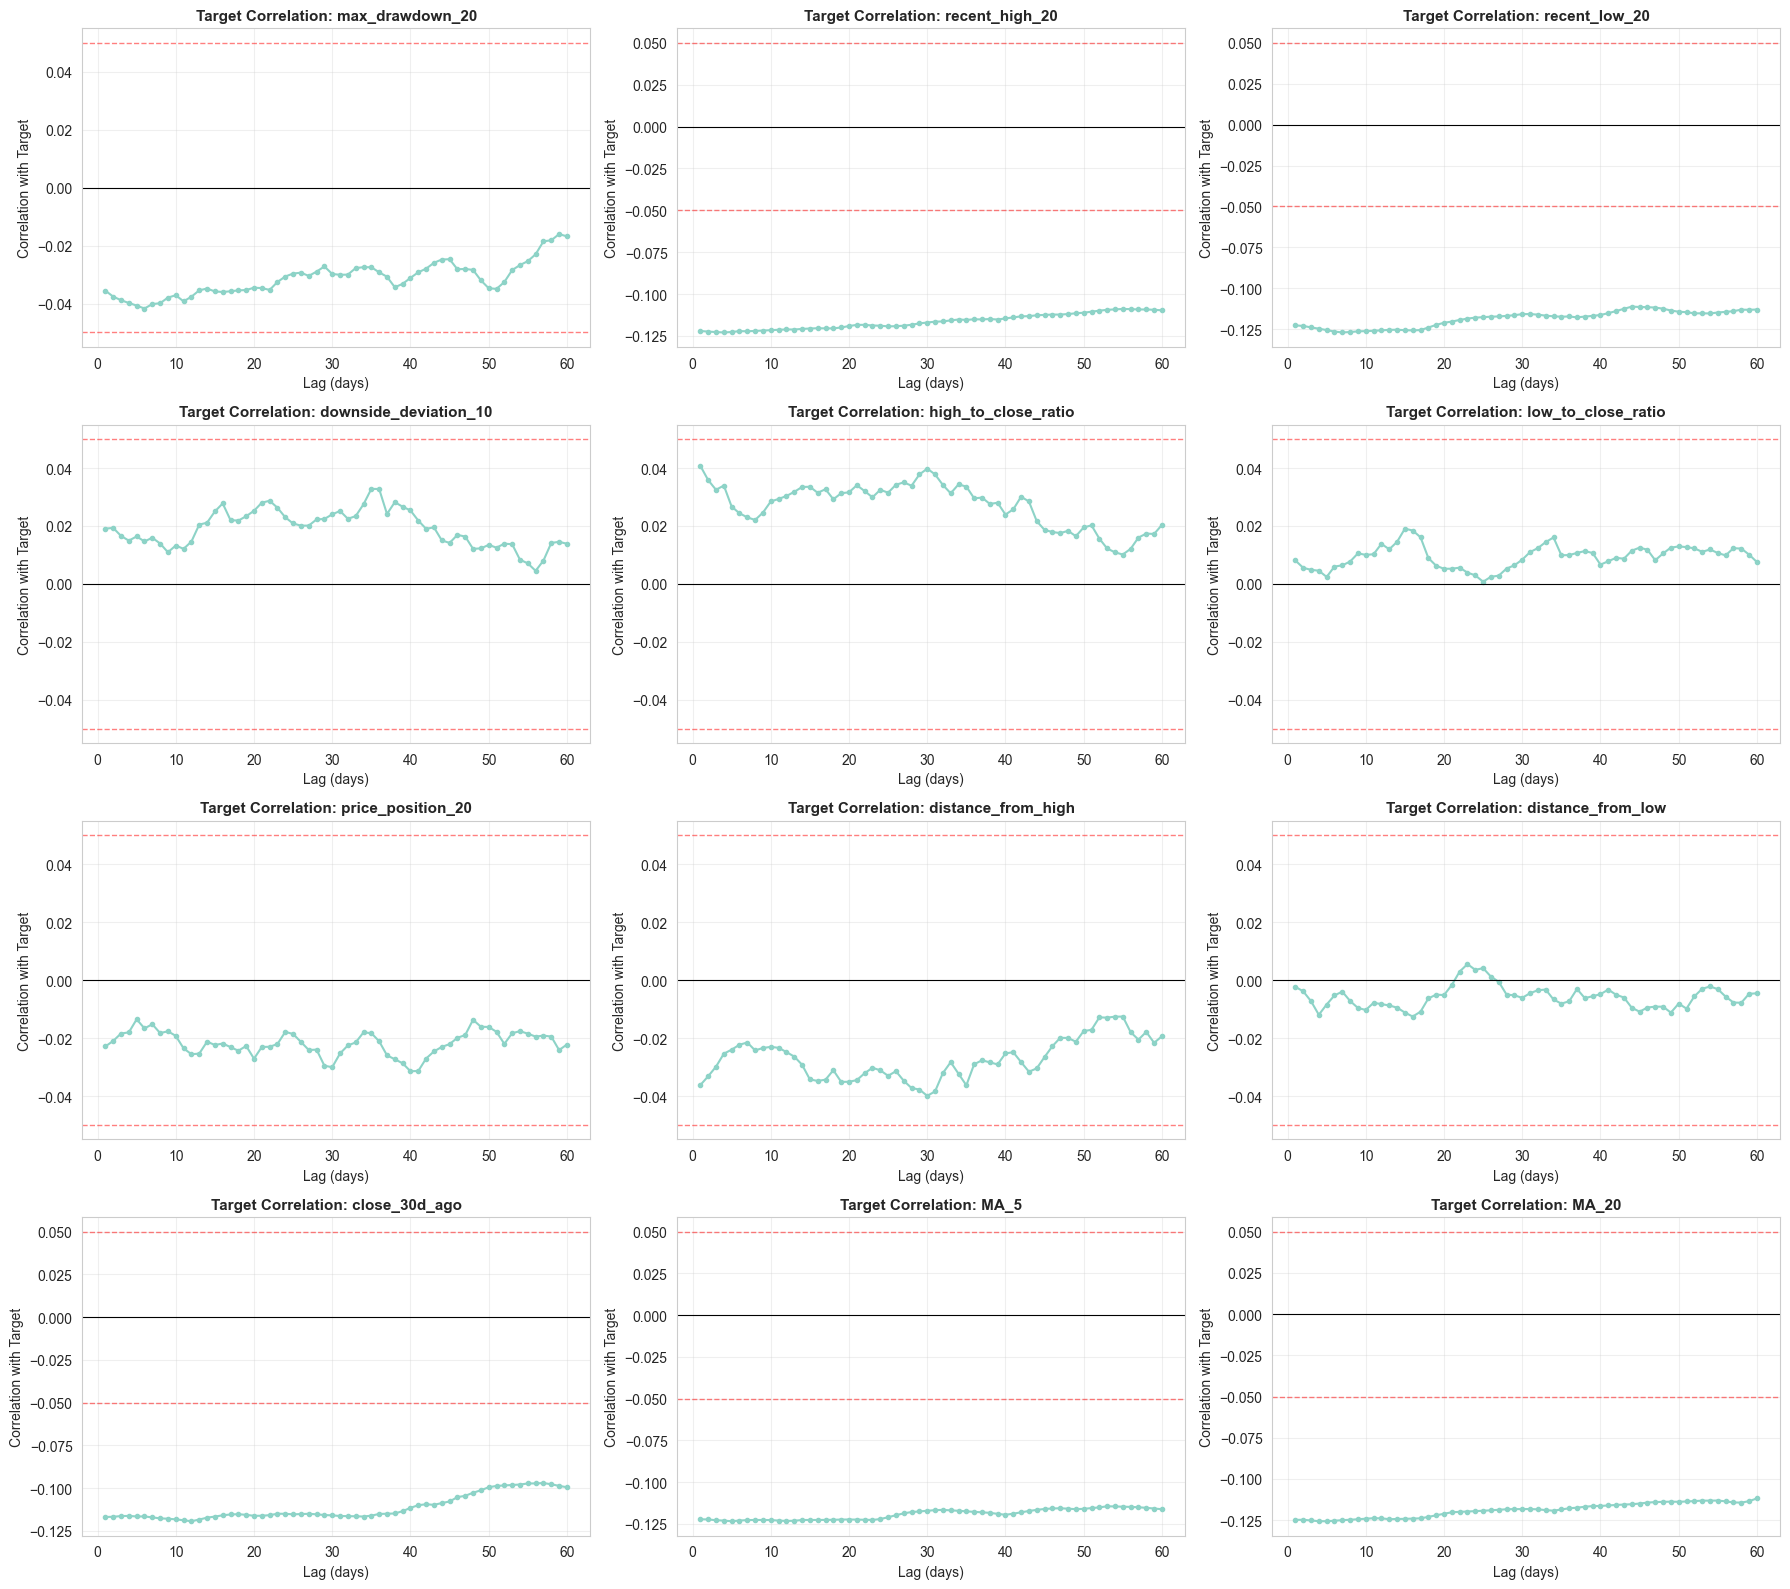


Analyzing target correlation: MA_60 (13/28)
  Peak correlation: -0.1204 at lag 9

Analyzing target correlation: price_to_MA5 (14/28)
  Peak correlation: -0.0216 at lag 4

Analyzing target correlation: price_to_MA20 (15/28)
  Peak correlation: -0.0336 at lag 19

Analyzing target correlation: price_to_MA60 (16/28)
  Peak correlation: -0.0566 at lag 7

Analyzing target correlation: MA_60_slope (17/28)
  Peak correlation: -0.0605 at lag 2

Analyzing target correlation: volatility_20 (18/28)
  Peak correlation: 0.0291 at lag 60

Analyzing target correlation: RSI_14 (19/28)
  Peak correlation: -0.0281 at lag 37

Analyzing target correlation: parkinson_volatility (20/28)
  Peak correlation: 0.0288 at lag 28

Analyzing target correlation: daily_return (21/28)
  Peak correlation: -0.0143 at lag 4

Analyzing target correlation: high_low_ratio (22/28)
  Peak correlation: 0.0228 at lag 2

Analyzing target correlation: return_30 (23/28)
  Peak correlation: -0.0474 at lag 19

Analyzing target corre

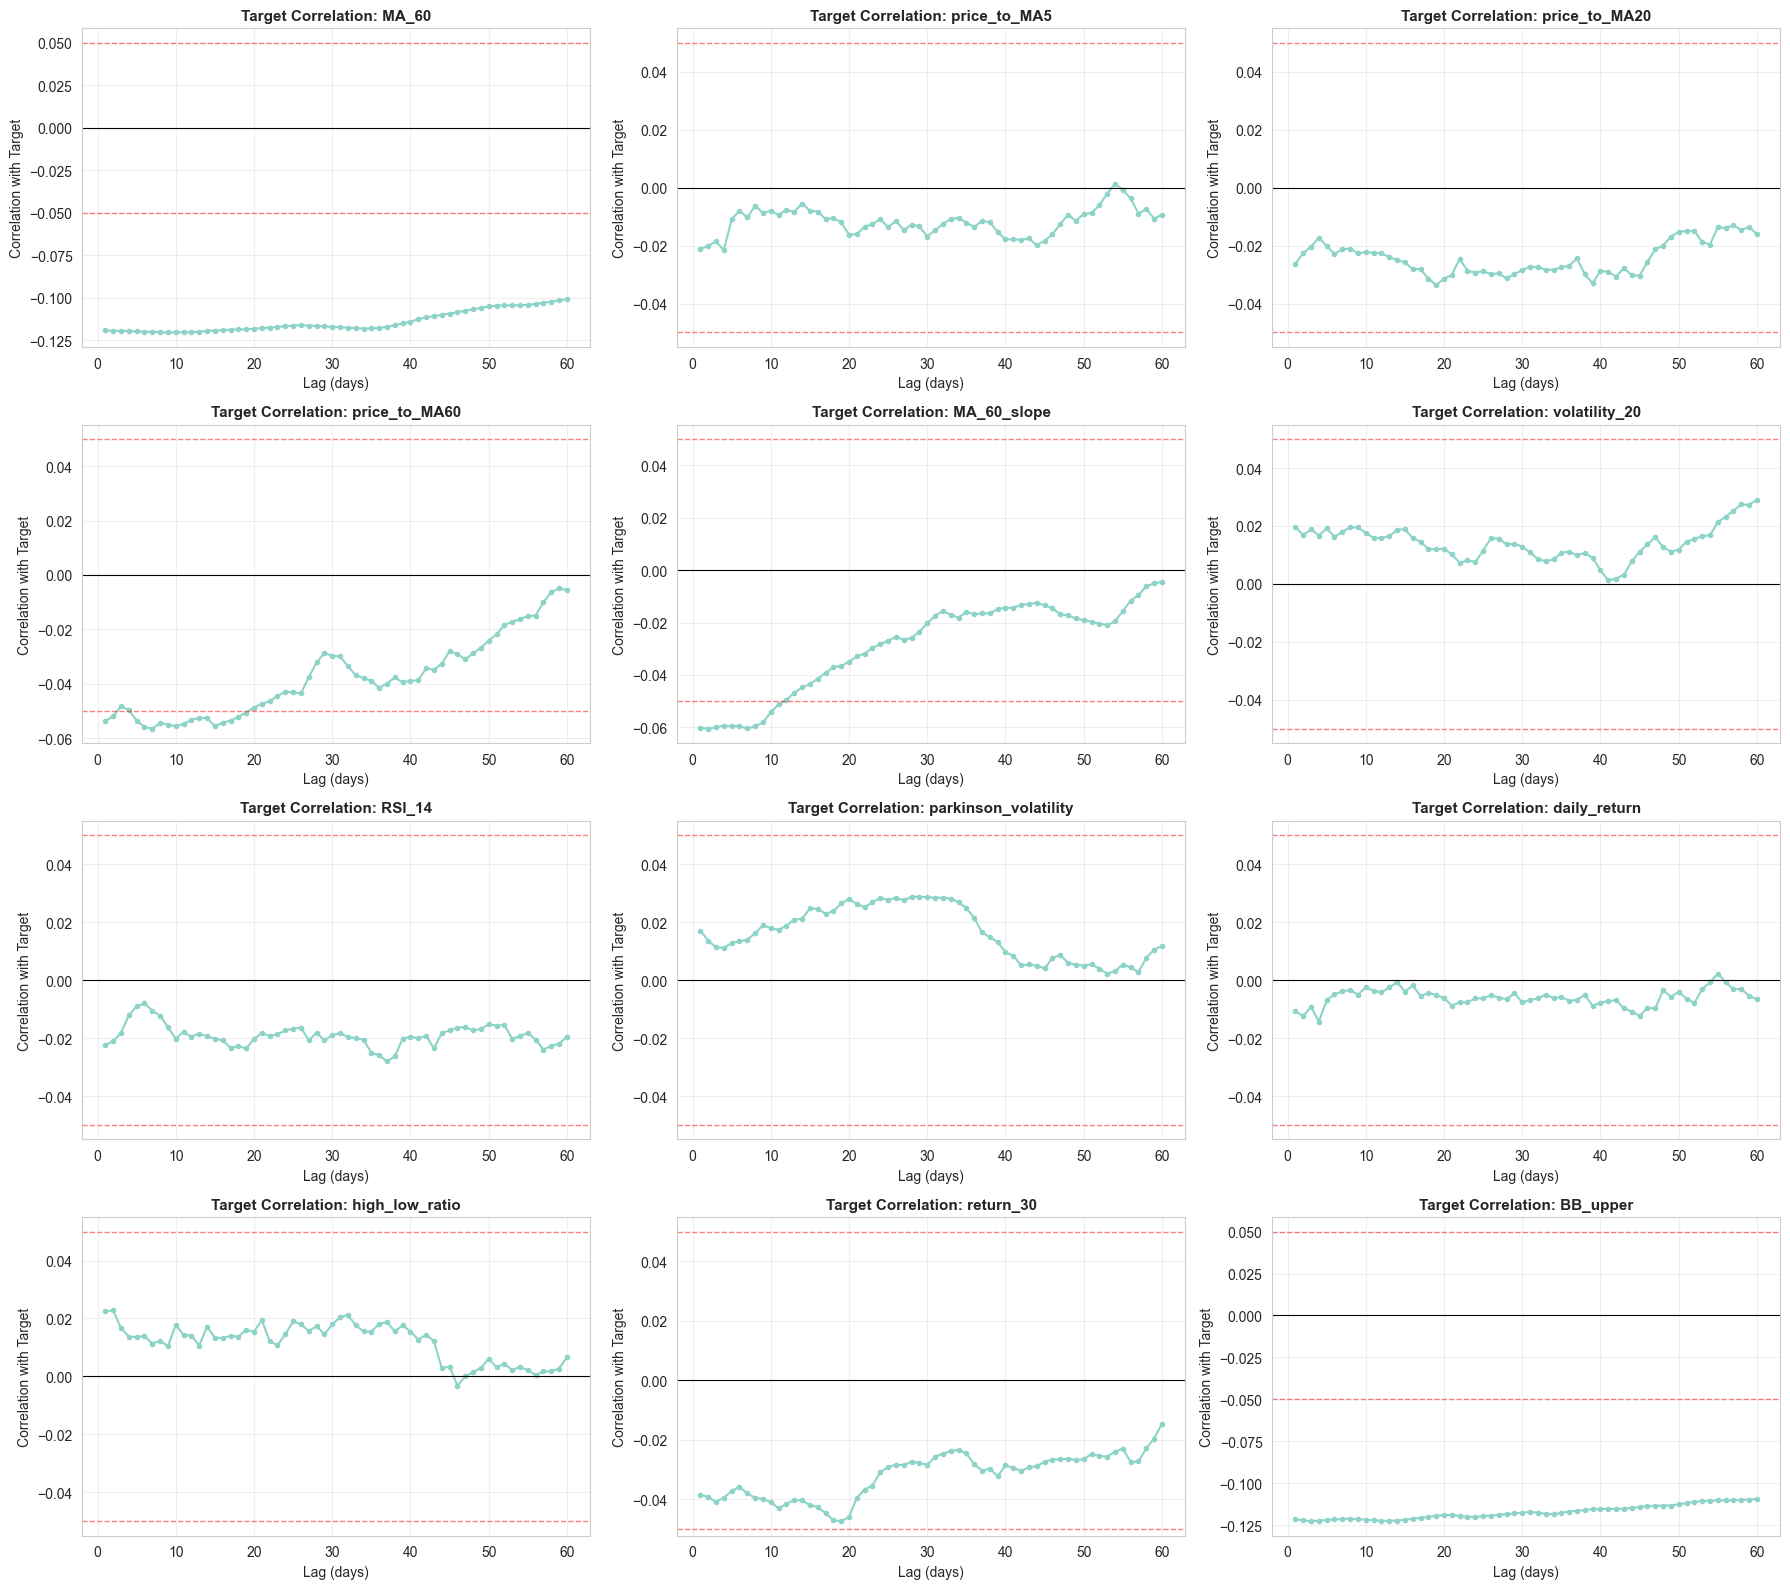


Analyzing target correlation: BB_lower (25/28)
  Peak correlation: -0.1259 at lag 5

Analyzing target correlation: month_sin (26/28)
  Peak correlation: -0.0729 at lag 45

Analyzing target correlation: month_cos (27/28)
  Peak correlation: 0.0834 at lag 16

Analyzing target correlation: is_up_day (28/28)
  Peak correlation: -0.0139 at lag 4

✓ Saved: 03_target_lag_correlation_part3.png


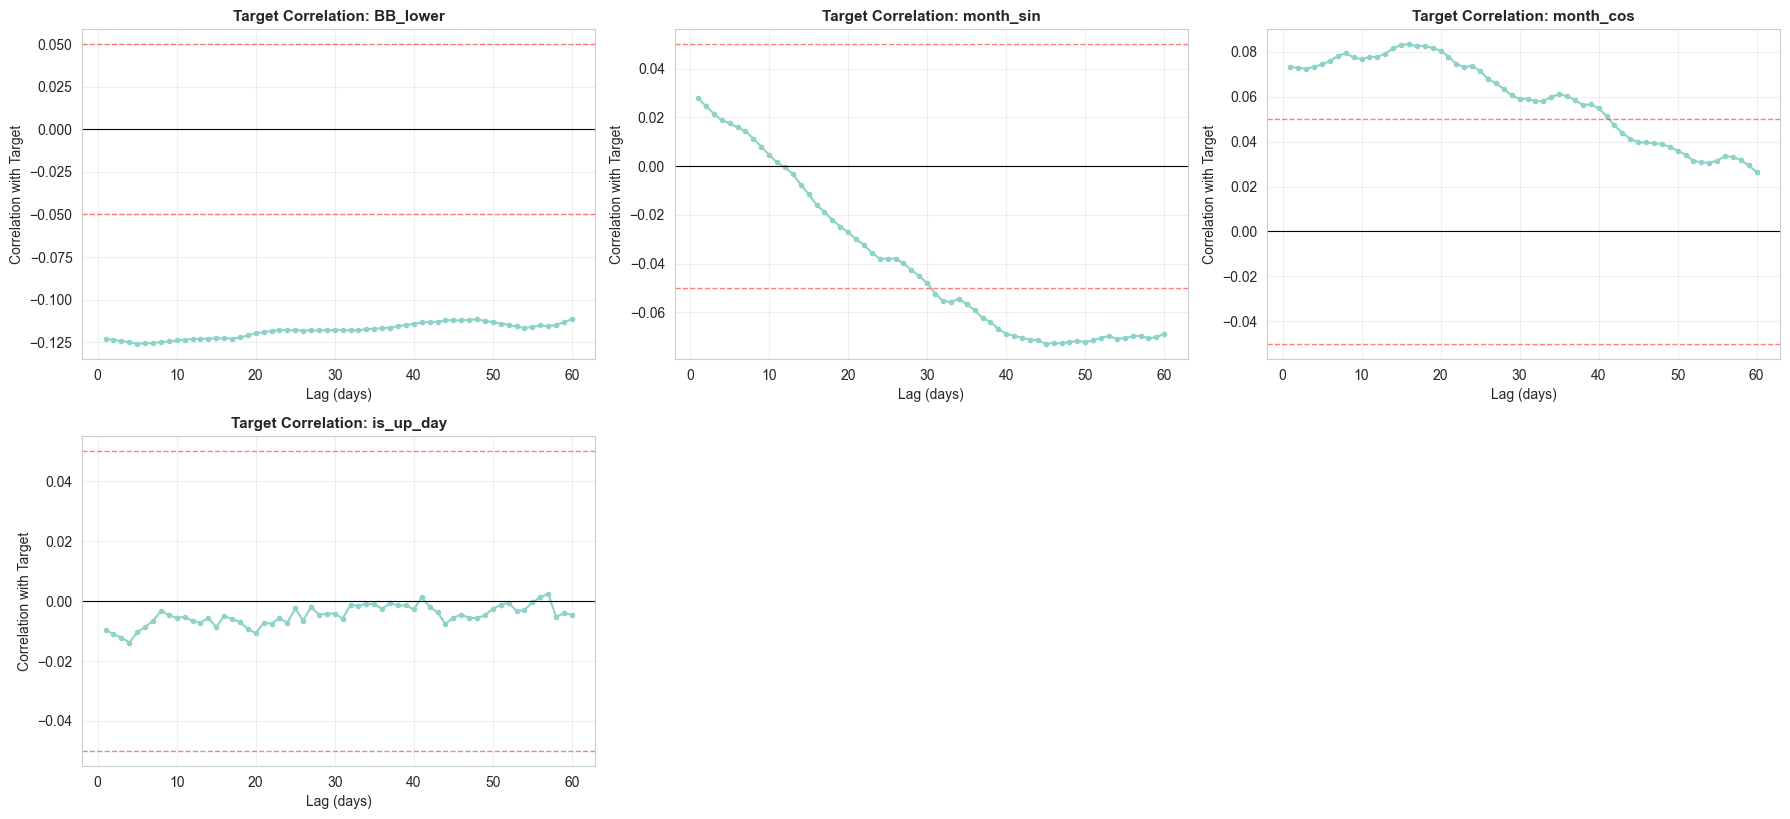


✓ Analysis complete! Created 3 figure(s)


In [64]:
# ============================================================================
# SECTION 5: TARGET-LAG CORRELATION ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("[5] TARGET-LAG CORRELATION ANALYSIS")
print("="*80)
print("Analyzing correlation between lagged features and target variable")

# ----------------------------------------------------------------------------
# CONFIGURATION
# ----------------------------------------------------------------------------
NUM_TICKERS_TO_USE = 50  # <<< CHANGE THIS TO CONTROL HOW MANY TICKERS ARE USED
max_lags = 60            # Should match SECTION 4 for consistency
PLOTS_PER_FIGURE = 12    # Number of subplots per figure (4x3 grid)

# ----------------------------------------------------------------------------
# PREPARE DATA (KEEP TEMPORAL ORDER)
# ----------------------------------------------------------------------------
df_features = df_features.sort_values(['ticker', 'date'])

selected_tickers = df_features['ticker'].dropna().unique()[:NUM_TICKERS_TO_USE]
df_sample = df_features.loc[df_features['ticker'].isin(selected_tickers)].copy()

# ----------------------------------------------------------------------------
# TARGET-LAG CORRELATION COMPUTATION
# ----------------------------------------------------------------------------
target_lag_results = {}

# Calculate how many figures we need
num_features = len(feature_columns)
num_figures = int(np.ceil(num_features / PLOTS_PER_FIGURE))

print(f"\nTotal features: {num_features}")
print(f"Plots per figure: {PLOTS_PER_FIGURE}")
print(f"Number of figures to create: {num_figures}")

# Initialize first figure
fig_idx = 0
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()
plot_idx_in_figure = 0

for feature_idx, feature in enumerate(feature_columns):
    print(f"\nAnalyzing target correlation: {feature} ({feature_idx+1}/{num_features})")

    correlations_per_lag = []

    # For each lag
    for lag in range(1, max_lags + 1):

        # Compute correlation per ticker
        per_ticker_corrs = []

        for ticker, g in df_sample.groupby('ticker'):
            ticker_data = g.sort_values('date').reset_index(drop=True)
            lagged_feature = ticker_data[feature].shift(lag)
            valid_mask = ticker_data['target'].notna() & lagged_feature.notna()

            if valid_mask.sum() > 30:  # Need at least 30 samples
                corr = ticker_data.loc[valid_mask, 'target'].corr(lagged_feature[valid_mask])
                per_ticker_corrs.append(corr)

        # Aggregate across tickers (median is robust)
        if len(per_ticker_corrs) > 0:
            correlations_per_lag.append(np.median(per_ticker_corrs))
        else:
            correlations_per_lag.append(0)

    target_lag_results[feature] = correlations_per_lag

    # ----------------------------------------------------------------------------
    # PLOT
    # ----------------------------------------------------------------------------
    axes[plot_idx_in_figure].plot(range(1, max_lags + 1), correlations_per_lag,
                   marker='o', markersize=3, linewidth=1.5)
    axes[plot_idx_in_figure].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    axes[plot_idx_in_figure].axhline(y=0.05, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[plot_idx_in_figure].axhline(y=-0.05, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[plot_idx_in_figure].set_title(f'Target Correlation: {feature}', fontsize=11, fontweight='bold')
    axes[plot_idx_in_figure].set_xlabel('Lag (days)')
    axes[plot_idx_in_figure].set_ylabel('Correlation with Target')
    axes[plot_idx_in_figure].grid(True, alpha=0.3)

    # ----------------------------------------------------------------------------
    # FIND PEAK CORRELATION
    # ----------------------------------------------------------------------------
    max_corr_idx = np.argmax(np.abs(correlations_per_lag))
    max_corr = correlations_per_lag[max_corr_idx]
    print(f"  Peak correlation: {max_corr:.4f} at lag {max_corr_idx + 1}")

    plot_idx_in_figure += 1

    # Check if we need to save current figure and start a new one
    if plot_idx_in_figure == PLOTS_PER_FIGURE or feature_idx == num_features - 1:
        # Hide any unused subplots in the current figure
        for unused_idx in range(plot_idx_in_figure, PLOTS_PER_FIGURE):
            axes[unused_idx].remove()

        plt.tight_layout()
        filename = f'03_target_lag_correlation_part{fig_idx+1}.png'
        plt.savefig(os.path.join(IMAGE_DIR, filename), dpi=300, bbox_inches='tight')
        print(f"\n✓ Saved: {filename}")
        plt.show()

        # Start new figure if there are more features to plot
        if feature_idx < num_features - 1:
            fig_idx += 1
            fig, axes = plt.subplots(4, 3, figsize=(18, 16))
            axes = axes.flatten()
            plot_idx_in_figure = 0

print("\n" + "="*80)
print(f"✓ Analysis complete! Created {fig_idx + 1} figure(s)")
print("="*80)


[6] TARGET-LAG MUTUAL INFORMATION ANALYSIS
Analyzing mutual information between lagged features and binary target

Total features: 28
Plots per figure: 12
Number of figures to create: 3

Analyzing MI with target: max_drawdown_20 (1/28)
  Peak MI: 0.3262 at lag 1

Analyzing MI with target: recent_high_20 (2/28)
  Peak MI: 0.2673 at lag 59

Analyzing MI with target: recent_low_20 (3/28)
  Peak MI: 0.2637 at lag 1

Analyzing MI with target: downside_deviation_10 (4/28)
  Peak MI: 0.1048 at lag 30

Analyzing MI with target: high_to_close_ratio (5/28)
  Peak MI: 0.0180 at lag 54

Analyzing MI with target: low_to_close_ratio (6/28)
  Peak MI: 0.0186 at lag 49

Analyzing MI with target: price_position_20 (7/28)
  Peak MI: 0.0119 at lag 50

Analyzing MI with target: distance_from_high (8/28)
  Peak MI: 0.0180 at lag 54

Analyzing MI with target: distance_from_low (9/28)
  Peak MI: 0.0187 at lag 49

Analyzing MI with target: close_30d_ago (10/28)
  Peak MI: 0.0203 at lag 1

Analyzing MI with t

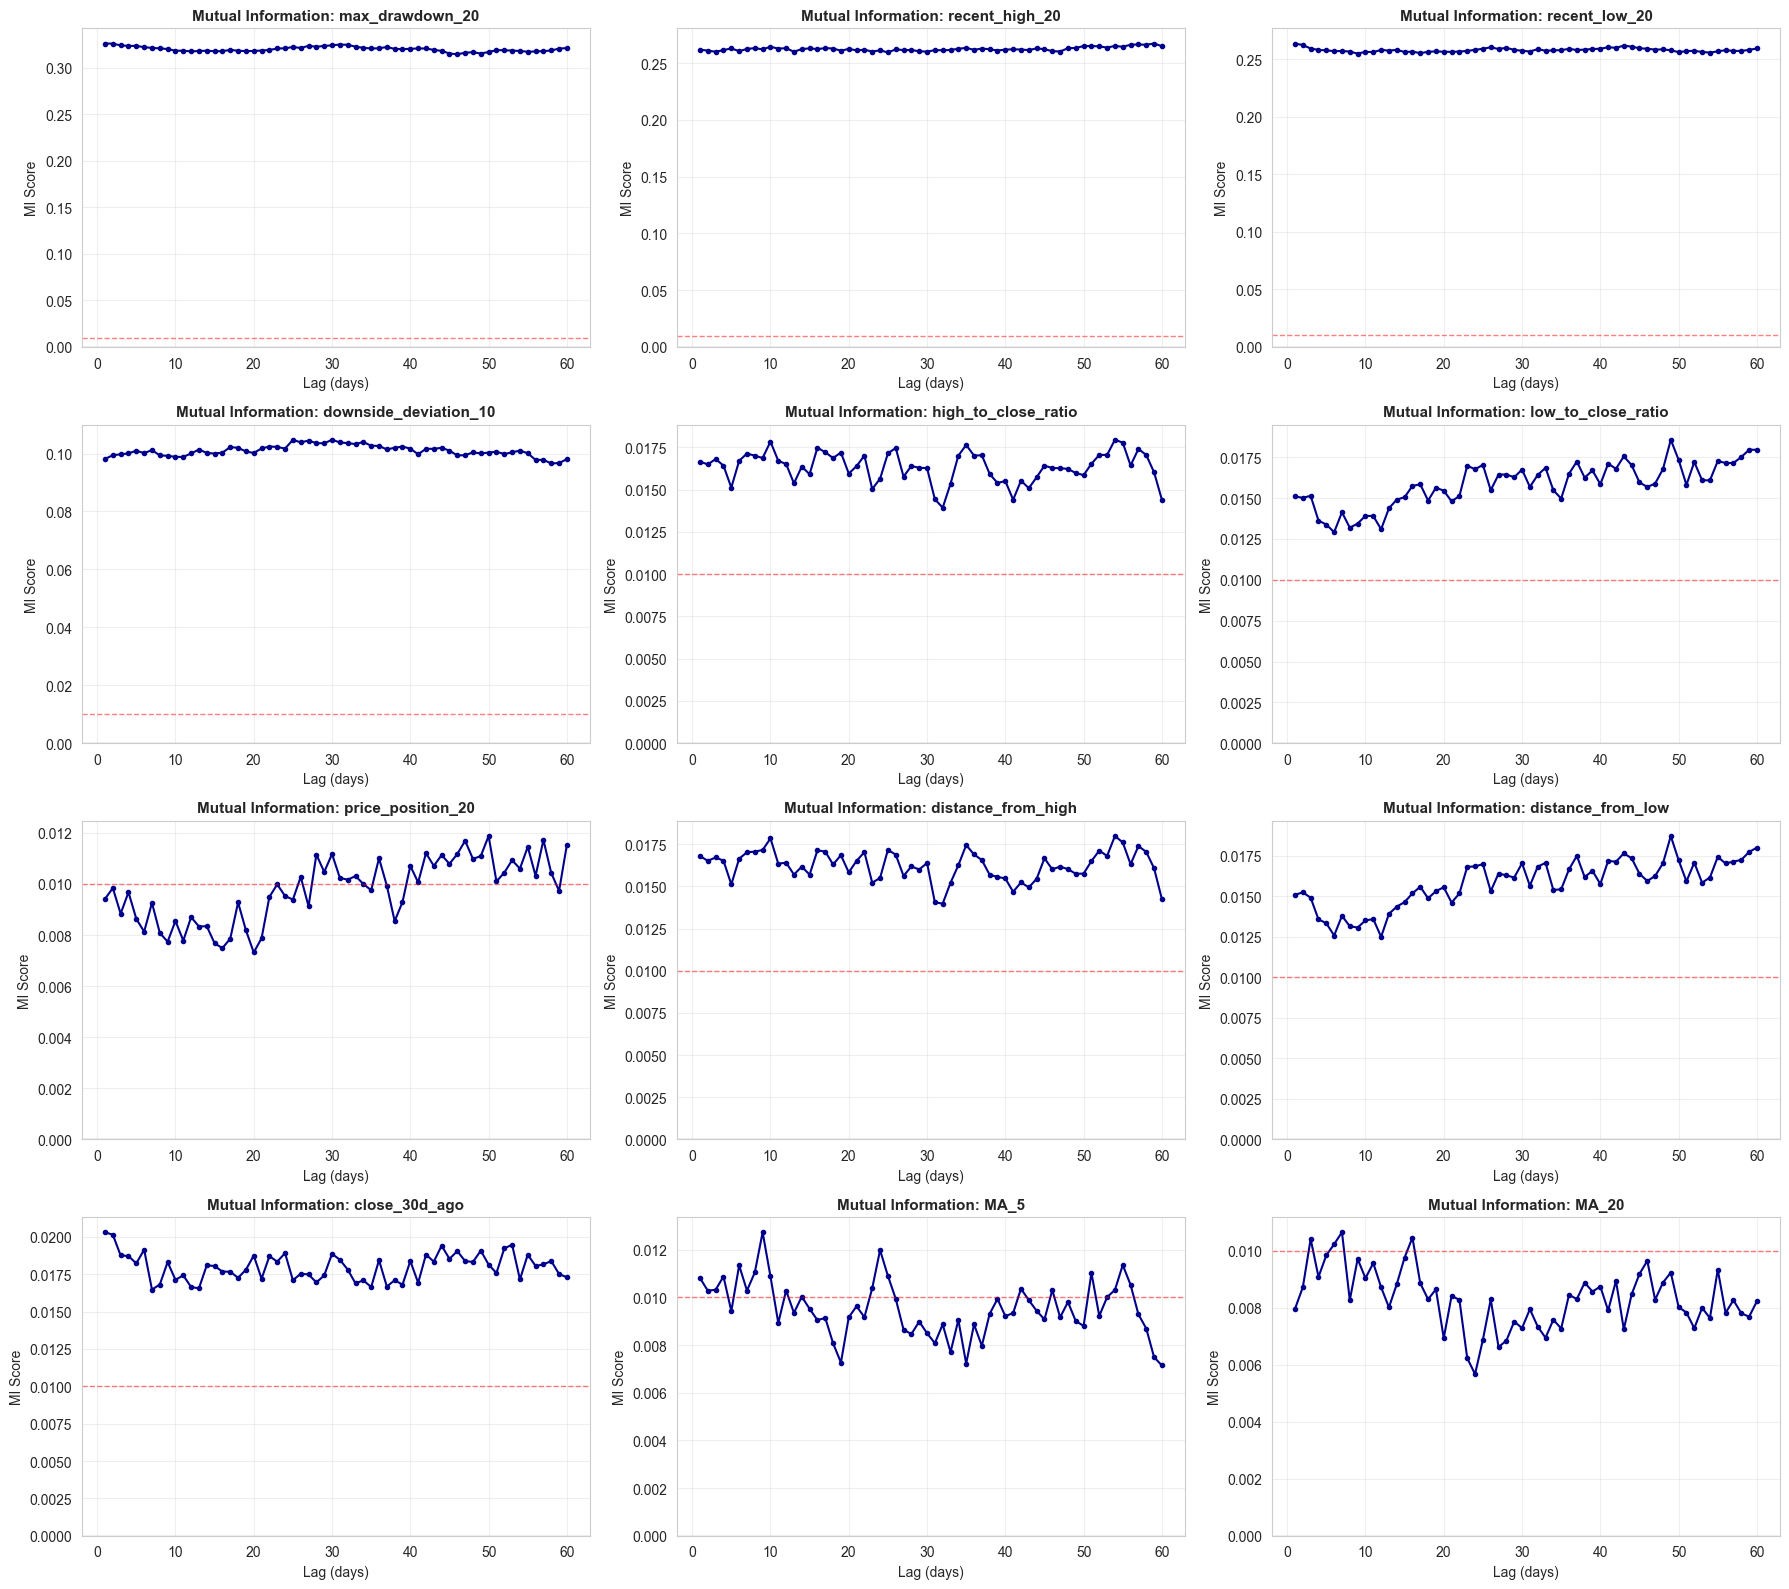


Analyzing MI with target: MA_60 (13/28)
  Peak MI: 0.0129 at lag 25

Analyzing MI with target: price_to_MA5 (14/28)
  Peak MI: 0.0032 at lag 11

Analyzing MI with target: price_to_MA20 (15/28)
  Peak MI: 0.0034 at lag 4

Analyzing MI with target: price_to_MA60 (16/28)
  Peak MI: 0.0041 at lag 22

Analyzing MI with target: MA_60_slope (17/28)
  Peak MI: 0.0041 at lag 6

Analyzing MI with target: volatility_20 (18/28)
  Peak MI: 0.0070 at lag 43

Analyzing MI with target: RSI_14 (19/28)
  Peak MI: 0.0066 at lag 40

Analyzing MI with target: parkinson_volatility (20/28)
  Peak MI: 0.0061 at lag 41

Analyzing MI with target: daily_return (21/28)
  Peak MI: 0.0041 at lag 31

Analyzing MI with target: high_low_ratio (22/28)
  Peak MI: 0.0046 at lag 30

Analyzing MI with target: return_30 (23/28)
  Peak MI: 0.0038 at lag 4

Analyzing MI with target: BB_upper (24/28)
  Peak MI: 0.0155 at lag 14

✓ Saved: 04_target_lag_mutual_information_part2.png


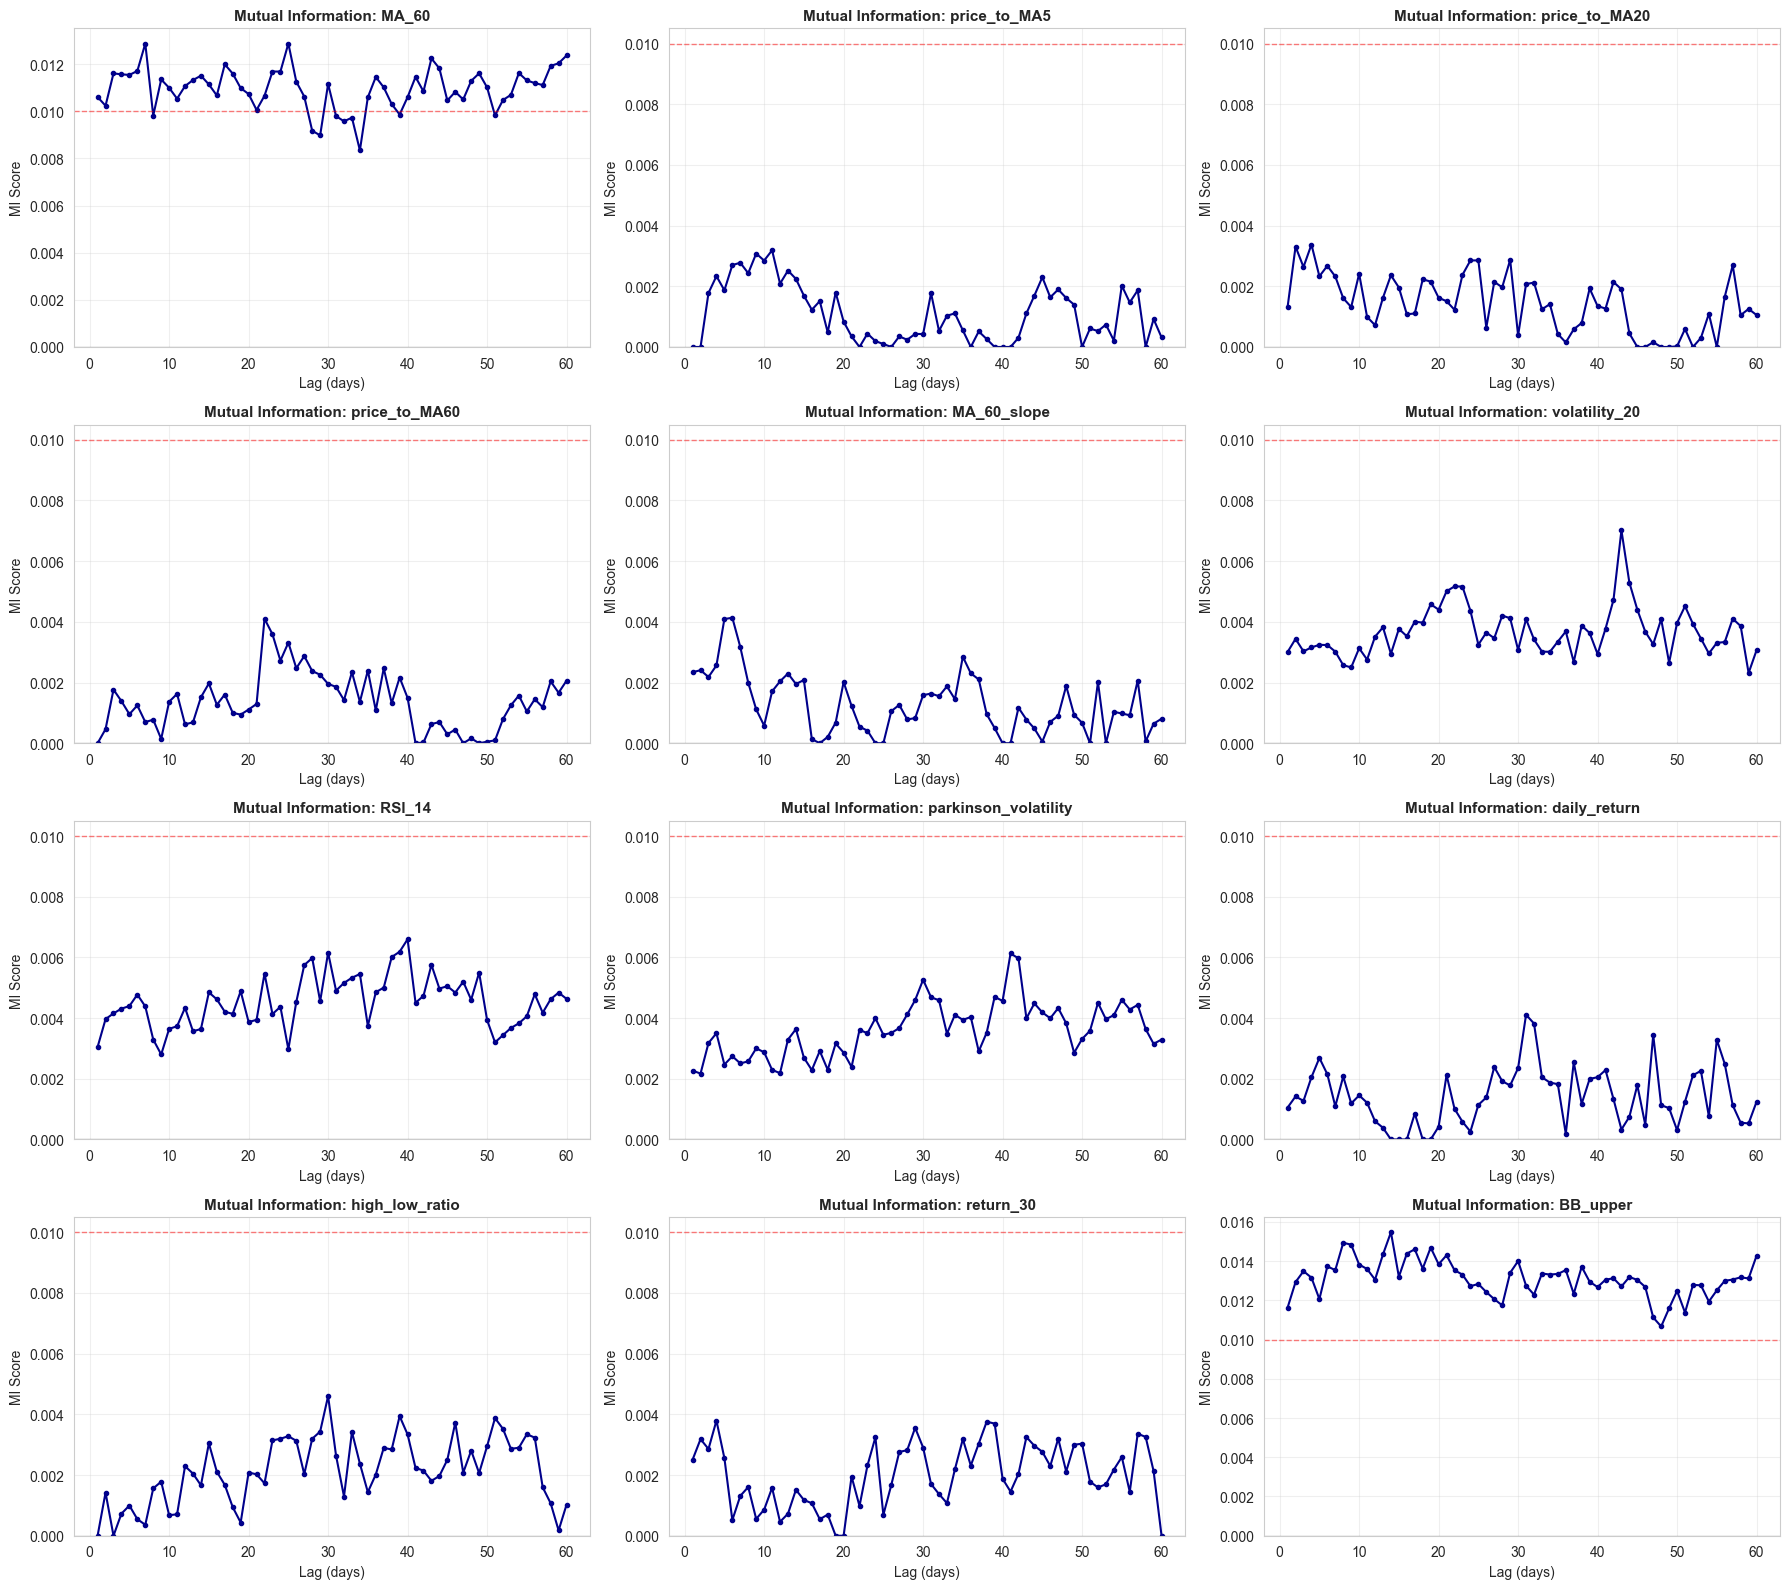


Analyzing MI with target: BB_lower (25/28)
  Peak MI: 0.0140 at lag 42

Analyzing MI with target: month_sin (26/28)
  Peak MI: 0.0087 at lag 49

Analyzing MI with target: month_cos (27/28)
  Peak MI: 0.0087 at lag 44

Analyzing MI with target: is_up_day (28/28)
  Peak MI: 0.0179 at lag 13

✓ Saved: 04_target_lag_mutual_information_part3.png


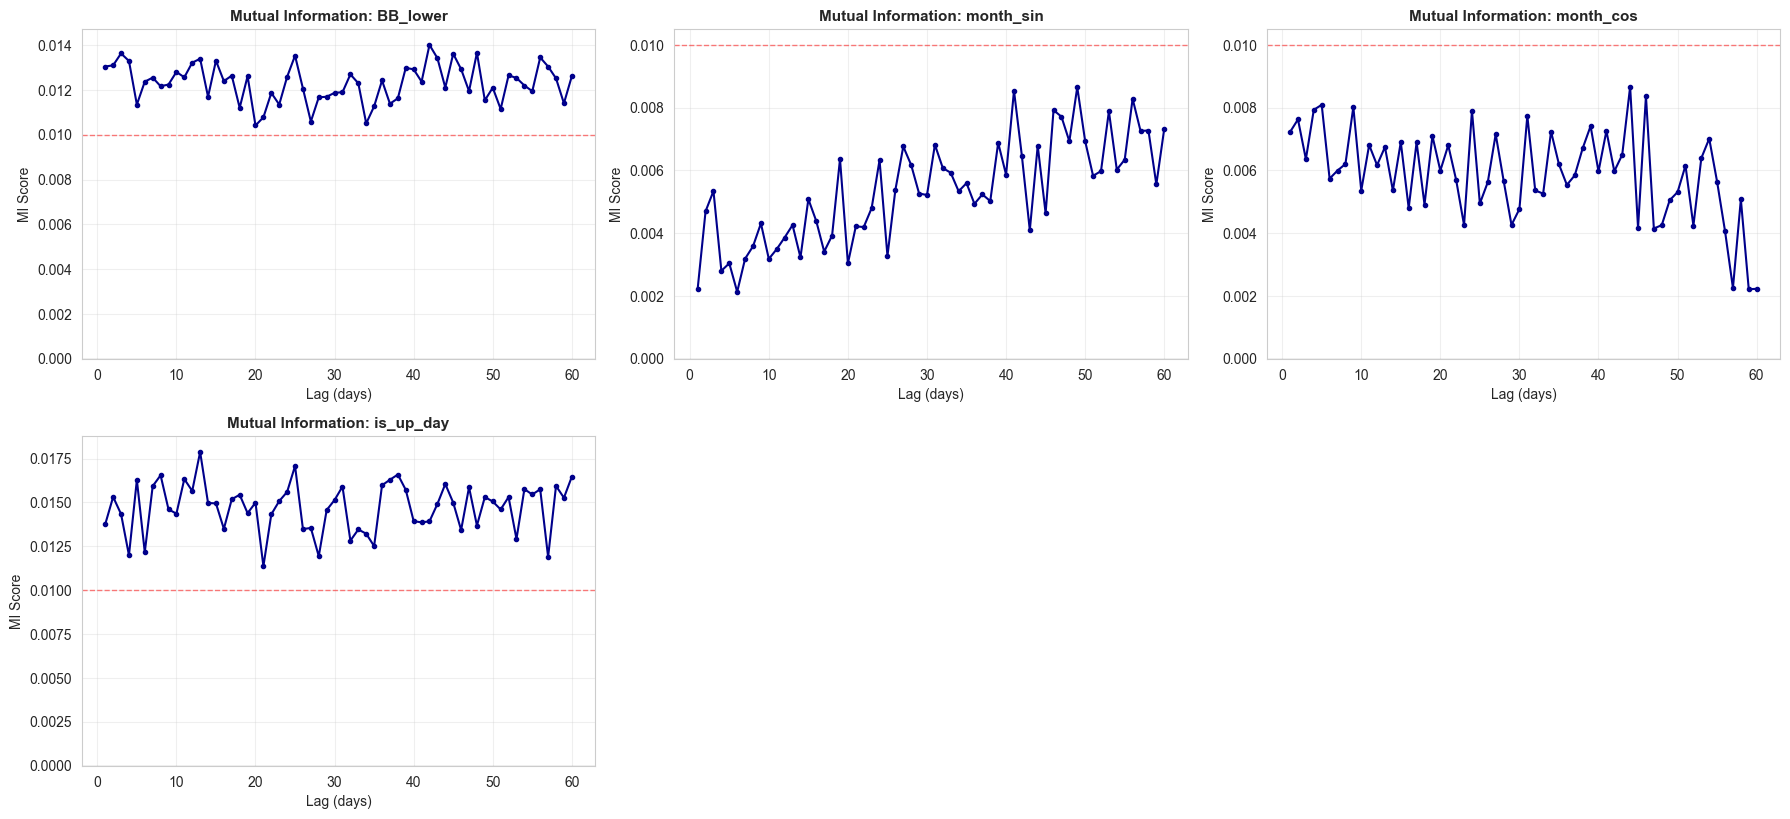


✓ Mutual Information analysis complete! Created 3 figure(s)

BONUS: CORRELATION vs MUTUAL INFORMATION COMPARISON

✓ Saved: 05_correlation_vs_MI_comparison_part1.png


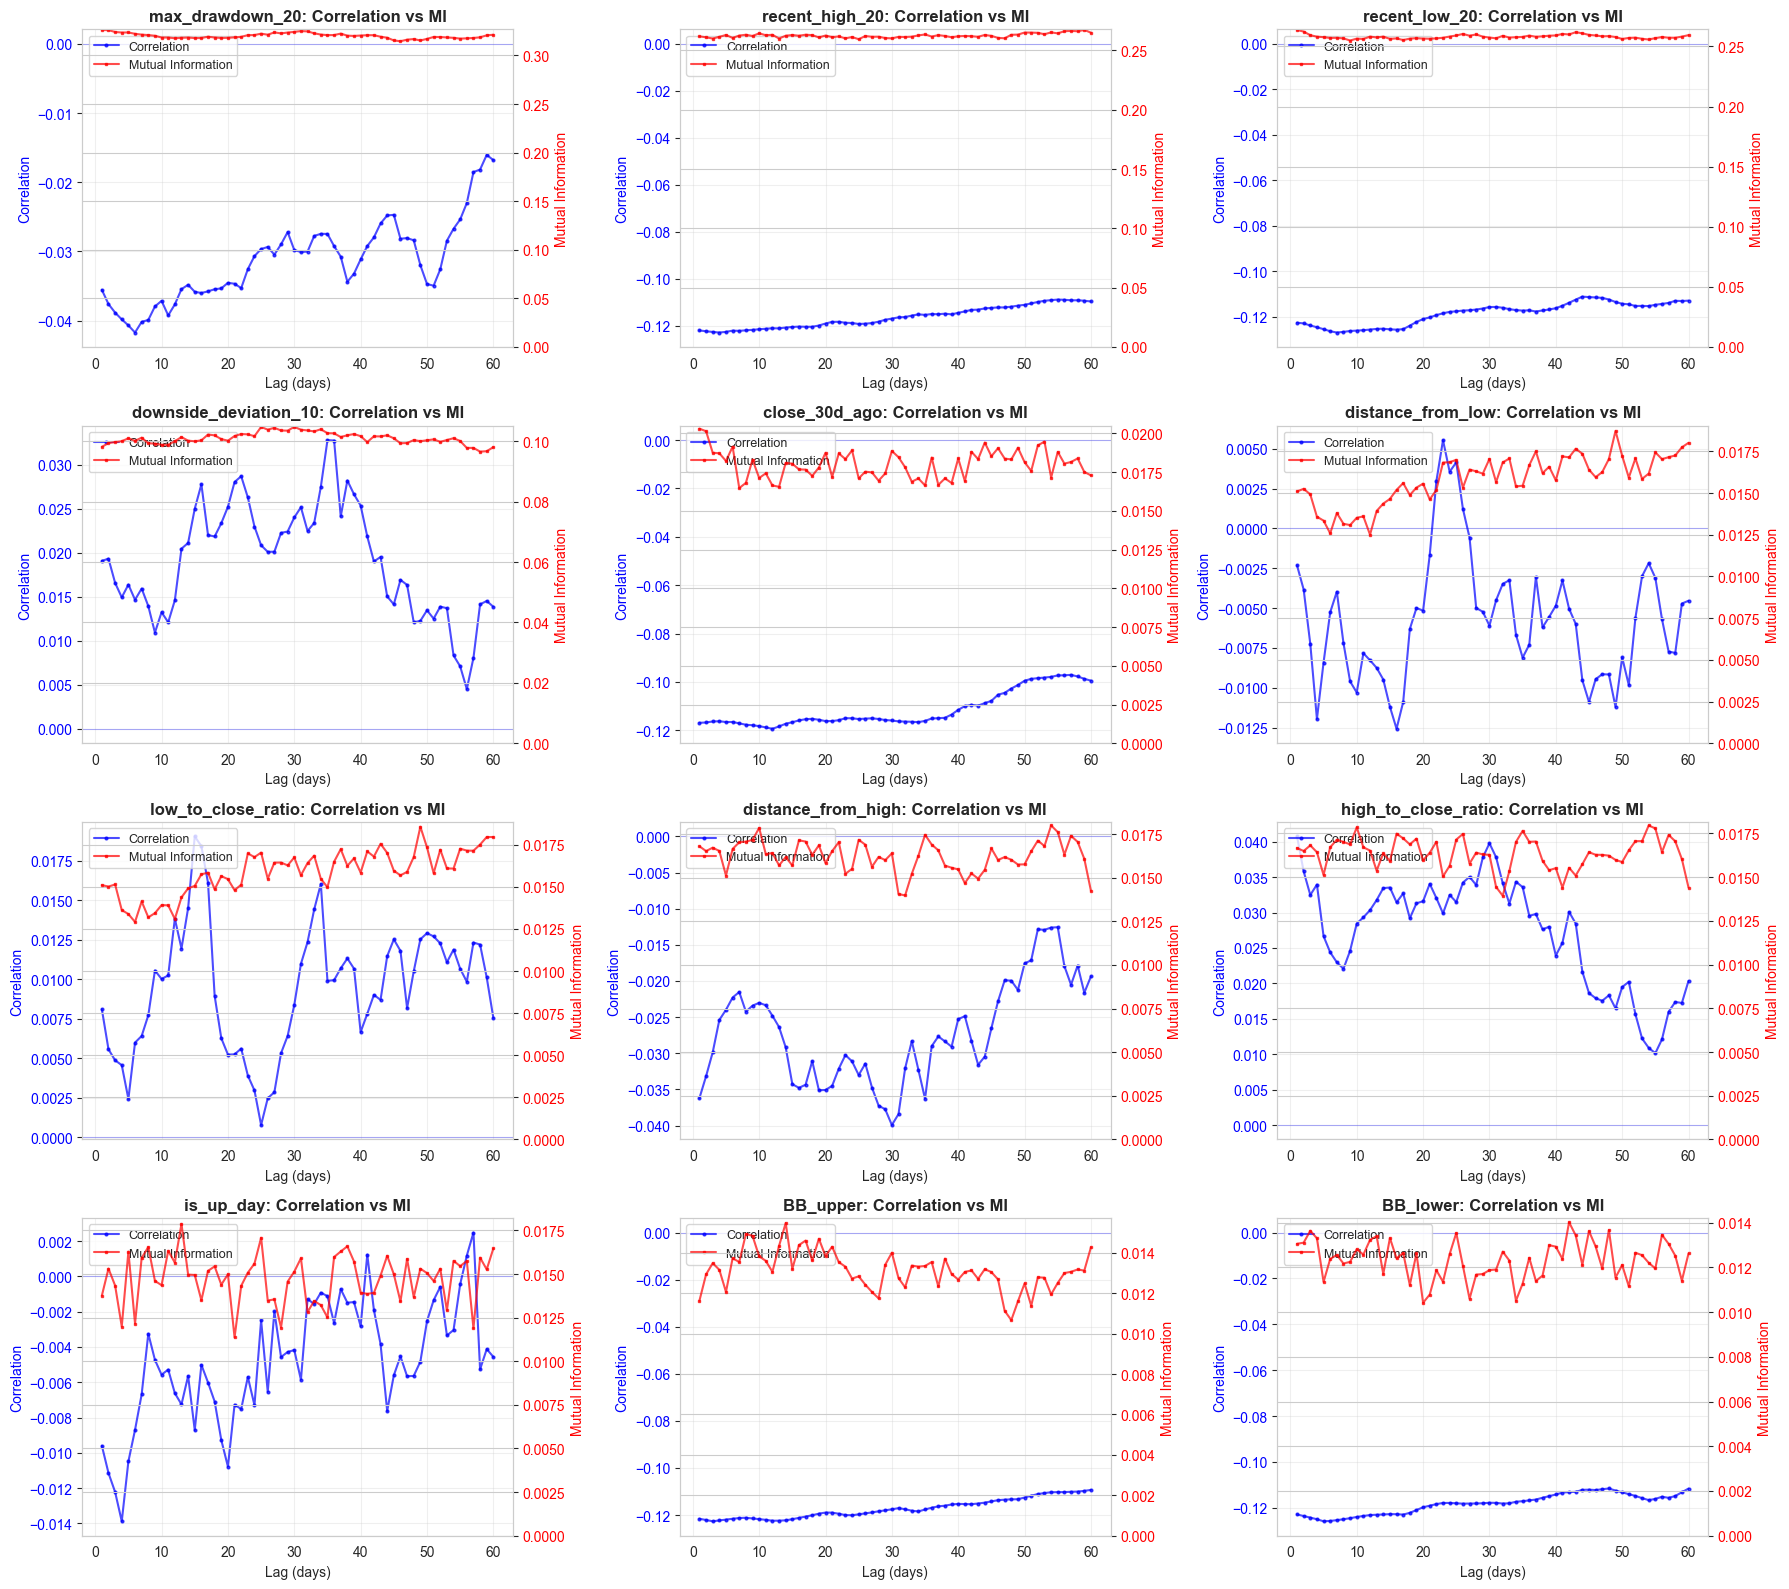


SUMMARY: TOP PREDICTIVE LAGS

Top Features by Mutual Information:
              Feature  Best_Corr  Best_Corr_Lag  Best_MI  Best_MI_Lag
      max_drawdown_20  -0.041726              6 0.326210            1
       recent_high_20  -0.122942              4 0.267346           59
        recent_low_20  -0.127007              7 0.263748            1
downside_deviation_10   0.032804             35 0.104759           30
        close_30d_ago  -0.119404             12 0.020312            1
    distance_from_low  -0.012568             16 0.018728           49
   low_to_close_ratio   0.019055             15 0.018568           49
   distance_from_high  -0.039933             30 0.017992           54
  high_to_close_ratio   0.040760              1 0.017953           54
            is_up_day  -0.013881              4 0.017874           13
             BB_upper  -0.122665              3 0.015474           14
             BB_lower  -0.125919              5 0.014018           42
                MA_60  

In [65]:
# ============================================================================
# SECTION 6: TARGET-LAG MUTUAL INFORMATION ANALYSIS
# ============================================================================

from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler

print("\n" + "="*80)
print("[6] TARGET-LAG MUTUAL INFORMATION ANALYSIS")
print("="*80)
print("Analyzing mutual information between lagged features and binary target")

# ----------------------------------------------------------------------------
# CONFIGURATION
# ----------------------------------------------------------------------------
NUM_TICKERS_TO_USE = 50  # <<< CHANGE THIS TO CONTROL HOW MANY TICKERS ARE USED
max_lags = 60            # Should match previous sections for consistency
PLOTS_PER_FIGURE = 12    # Number of subplots per figure (4x3 grid)

# ----------------------------------------------------------------------------
# PREPARE DATA (KEEP TEMPORAL ORDER)
# ----------------------------------------------------------------------------
df_features = df_features.sort_values(['ticker', 'date'])

selected_tickers = df_features['ticker'].dropna().unique()[:NUM_TICKERS_TO_USE]
df_sample = df_features.loc[df_features['ticker'].isin(selected_tickers)].copy()

# ----------------------------------------------------------------------------
# TARGET-LAG MUTUAL INFORMATION COMPUTATION
# ----------------------------------------------------------------------------
target_mi_results = {}

# Calculate how many figures we need
num_features = len(feature_columns)
num_figures = int(np.ceil(num_features / PLOTS_PER_FIGURE))

print(f"\nTotal features: {num_features}")
print(f"Plots per figure: {PLOTS_PER_FIGURE}")
print(f"Number of figures to create: {num_figures}")

# Initialize first figure
fig_idx = 0
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()
plot_idx_in_figure = 0

for feature_idx, feature in enumerate(feature_columns):
    print(f"\nAnalyzing MI with target: {feature} ({feature_idx+1}/{num_features})")

    mi_scores_per_lag = []

    # For each lag
    for lag in range(1, max_lags + 1):

        # Collect all valid samples across tickers
        X_lag = []
        y_lag = []

        for ticker, g in df_sample.groupby('ticker'):
            ticker_data = g.sort_values('date').reset_index(drop=True)
            lagged_feature = ticker_data[feature].shift(lag)
            valid_mask = ticker_data['target'].notna() & lagged_feature.notna()

            if valid_mask.sum() > 0:
                X_lag.extend(lagged_feature[valid_mask].values)
                y_lag.extend(ticker_data.loc[valid_mask, 'target'].values)

        # Compute mutual information if we have enough samples
        if len(X_lag) > 30:
            X_lag = np.array(X_lag).reshape(-1, 1)
            y_lag = np.array(y_lag)

            # Mutual information estimation
            # random_state for reproducibility
            mi = mutual_info_classif(X_lag, y_lag,
                                    discrete_features=False,
                                    n_neighbors=3,
                                    random_state=42)[0]
            mi_scores_per_lag.append(mi)
        else:
            mi_scores_per_lag.append(0)

    target_mi_results[feature] = mi_scores_per_lag

    # ----------------------------------------------------------------------------
    # PLOT
    # ----------------------------------------------------------------------------
    axes[plot_idx_in_figure].plot(range(1, max_lags + 1), mi_scores_per_lag,
                   marker='o', markersize=3, linewidth=1.5, color='darkblue')
    axes[plot_idx_in_figure].axhline(y=0, color='black', linestyle='-', linewidth=0.8)

    # Add threshold line (optional - 0.01 is a reasonable baseline)
    axes[plot_idx_in_figure].axhline(y=0.01, color='red', linestyle='--',
                     linewidth=1, alpha=0.5, label='Threshold')

    axes[plot_idx_in_figure].set_title(f'Mutual Information: {feature}',
                       fontsize=11, fontweight='bold')
    axes[plot_idx_in_figure].set_xlabel('Lag (days)')
    axes[plot_idx_in_figure].set_ylabel('MI Score')
    axes[plot_idx_in_figure].grid(True, alpha=0.3)
    axes[plot_idx_in_figure].set_ylim(bottom=0)  # MI is always non-negative

    # ----------------------------------------------------------------------------
    # FIND PEAK MI
    # ----------------------------------------------------------------------------
    max_mi_idx = np.argmax(mi_scores_per_lag)
    max_mi = mi_scores_per_lag[max_mi_idx]
    print(f"  Peak MI: {max_mi:.4f} at lag {max_mi_idx + 1}")

    plot_idx_in_figure += 1

    # Check if we need to save current figure and start a new one
    if plot_idx_in_figure == PLOTS_PER_FIGURE or feature_idx == num_features - 1:
        # Hide any unused subplots in the current figure
        for unused_idx in range(plot_idx_in_figure, PLOTS_PER_FIGURE):
            axes[unused_idx].remove()

        plt.tight_layout()
        filename = f'04_target_lag_mutual_information_part{fig_idx+1}.png'
        plt.savefig(os.path.join(IMAGE_DIR, filename), dpi=300, bbox_inches='tight')
        print(f"\n✓ Saved: {filename}")
        plt.show()

        # Start new figure if there are more features to plot
        if feature_idx < num_features - 1:
            fig_idx += 1
            fig, axes = plt.subplots(4, 3, figsize=(18, 16))
            axes = axes.flatten()
            plot_idx_in_figure = 0

print("\n" + "="*80)
print(f"✓ Mutual Information analysis complete! Created {fig_idx + 1} figure(s)")
print("="*80)

# ============================================================================
# OPTIONAL: COMPARISON PLOT - CORRELATION vs MUTUAL INFORMATION
# ============================================================================

print("\n" + "="*80)
print("BONUS: CORRELATION vs MUTUAL INFORMATION COMPARISON")
print("="*80)

# Create comparison plot for top features by MI (select top 12)
# Sort features by max MI score
feature_max_mi = {feat: max(target_mi_results[feat])
                  for feat in feature_columns if feat in target_mi_results}
top_features = sorted(feature_max_mi.items(), key=lambda x: x[1], reverse=True)[:12]
comparison_features = [feat for feat, _ in top_features]

# Calculate number of comparison figures needed
num_comp_plots = len(comparison_features)
num_comp_figures = int(np.ceil(num_comp_plots / PLOTS_PER_FIGURE))

for comp_fig_idx in range(num_comp_figures):
    start_idx = comp_fig_idx * PLOTS_PER_FIGURE
    end_idx = min(start_idx + PLOTS_PER_FIGURE, num_comp_plots)
    features_in_figure = comparison_features[start_idx:end_idx]

    fig, axes = plt.subplots(4, 3, figsize=(18, 16))
    axes = axes.flatten()

    for idx, feature in enumerate(features_in_figure):
        if feature in target_lag_results and feature in target_mi_results:

            # Create twin axis
            ax1 = axes[idx]
            ax2 = ax1.twinx()

            # Plot correlation
            lags = range(1, max_lags + 1)
            line1 = ax1.plot(lags, target_lag_results[feature],
                            color='blue', marker='o', markersize=2,
                            linewidth=1.5, label='Correlation', alpha=0.7)
            ax1.axhline(y=0, color='blue', linestyle='-', linewidth=0.8, alpha=0.3)
            ax1.set_xlabel('Lag (days)', fontsize=10)
            ax1.set_ylabel('Correlation', color='blue', fontsize=10)
            ax1.tick_params(axis='y', labelcolor='blue')

            # Plot MI
            line2 = ax2.plot(lags, target_mi_results[feature],
                            color='red', marker='s', markersize=2,
                            linewidth=1.5, label='Mutual Information', alpha=0.7)
            ax2.set_ylabel('Mutual Information', color='red', fontsize=10)
            ax2.tick_params(axis='y', labelcolor='red')
            ax2.set_ylim(bottom=0)

            # Title and legend
            ax1.set_title(f'{feature}: Correlation vs MI',
                         fontsize=12, fontweight='bold')
            ax1.grid(True, alpha=0.3)

            # Combined legend
            lines = line1 + line2
            labels = [l.get_label() for l in lines]
            ax1.legend(lines, labels, loc='upper left', fontsize=9)

    # Hide unused subplots
    for unused_idx in range(len(features_in_figure), PLOTS_PER_FIGURE):
        axes[unused_idx].remove()

    plt.tight_layout()
    filename = f'05_correlation_vs_MI_comparison_part{comp_fig_idx+1}.png'
    plt.savefig(os.path.join(IMAGE_DIR, filename), dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved: {filename}")
    plt.show()

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

print("\n" + "="*80)
print("SUMMARY: TOP PREDICTIVE LAGS")
print("="*80)

summary_data = []

for feature in feature_columns:
    if feature in target_lag_results and feature in target_mi_results:

        # Best correlation
        corr_values = target_lag_results[feature]
        best_corr_idx = np.argmax(np.abs(corr_values))
        best_corr = corr_values[best_corr_idx]

        # Best MI
        mi_values = target_mi_results[feature]
        best_mi_idx = np.argmax(mi_values)
        best_mi = mi_values[best_mi_idx]

        summary_data.append({
            'Feature': feature,
            'Best_Corr': best_corr,
            'Best_Corr_Lag': best_corr_idx + 1,
            'Best_MI': best_mi,
            'Best_MI_Lag': best_mi_idx + 1
        })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Best_MI', ascending=False)

print("\nTop Features by Mutual Information:")
print(summary_df.head(20).to_string(index=False))  # Show top 20
print(f"\n... and {len(summary_df) - 20} more features")

# Save summary
summary_df.to_csv('target_lag_analysis_summary.csv', index=False)
print("\n✓ Saved: target_lag_analysis_summary.csv")


[7] ROLLING STATISTICS ANALYSIS
Analyzing stability of features across different window sizes

Total features: 28
Plots per figure: 12
Number of figures to create: 3
Analyzing rolling stats: max_drawdown_20 (1/28)
Analyzing rolling stats: recent_high_20 (2/28)
Analyzing rolling stats: recent_low_20 (3/28)
Analyzing rolling stats: downside_deviation_10 (4/28)
Analyzing rolling stats: high_to_close_ratio (5/28)
Analyzing rolling stats: low_to_close_ratio (6/28)
Analyzing rolling stats: price_position_20 (7/28)
Analyzing rolling stats: distance_from_high (8/28)
Analyzing rolling stats: distance_from_low (9/28)
Analyzing rolling stats: close_30d_ago (10/28)
Analyzing rolling stats: MA_5 (11/28)
Analyzing rolling stats: MA_20 (12/28)
Analyzing rolling stats: MA_60 (13/28)
Analyzing rolling stats: price_to_MA5 (14/28)
Analyzing rolling stats: price_to_MA20 (15/28)
Analyzing rolling stats: price_to_MA60 (16/28)
Analyzing rolling stats: MA_60_slope (17/28)
Analyzing rolling stats: volatility_

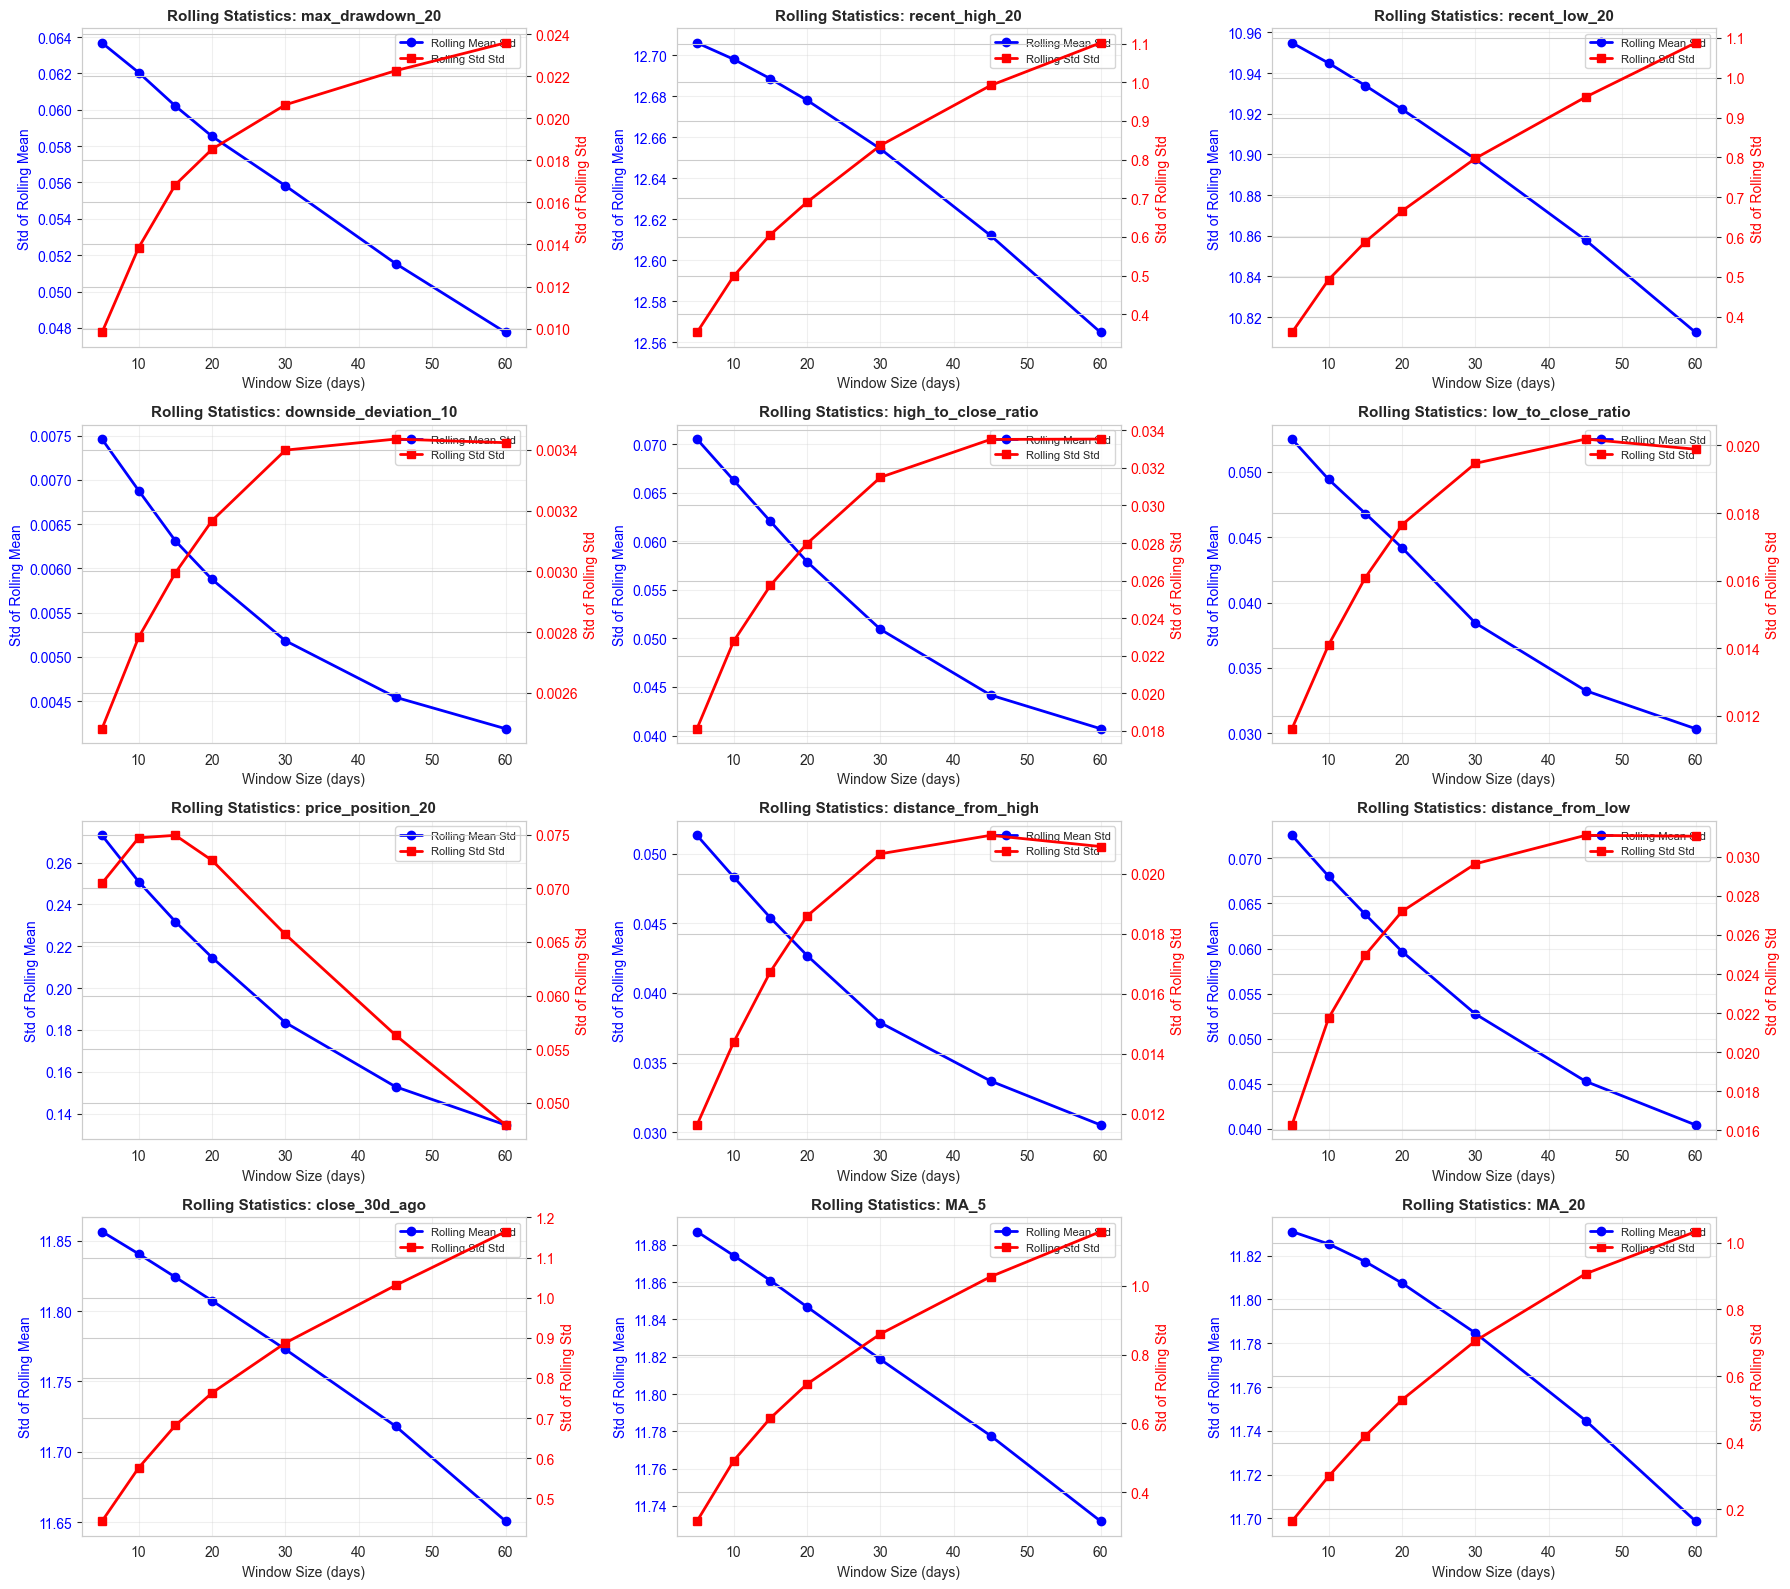


✓ Saved: 06_rolling_statistics_part2.png


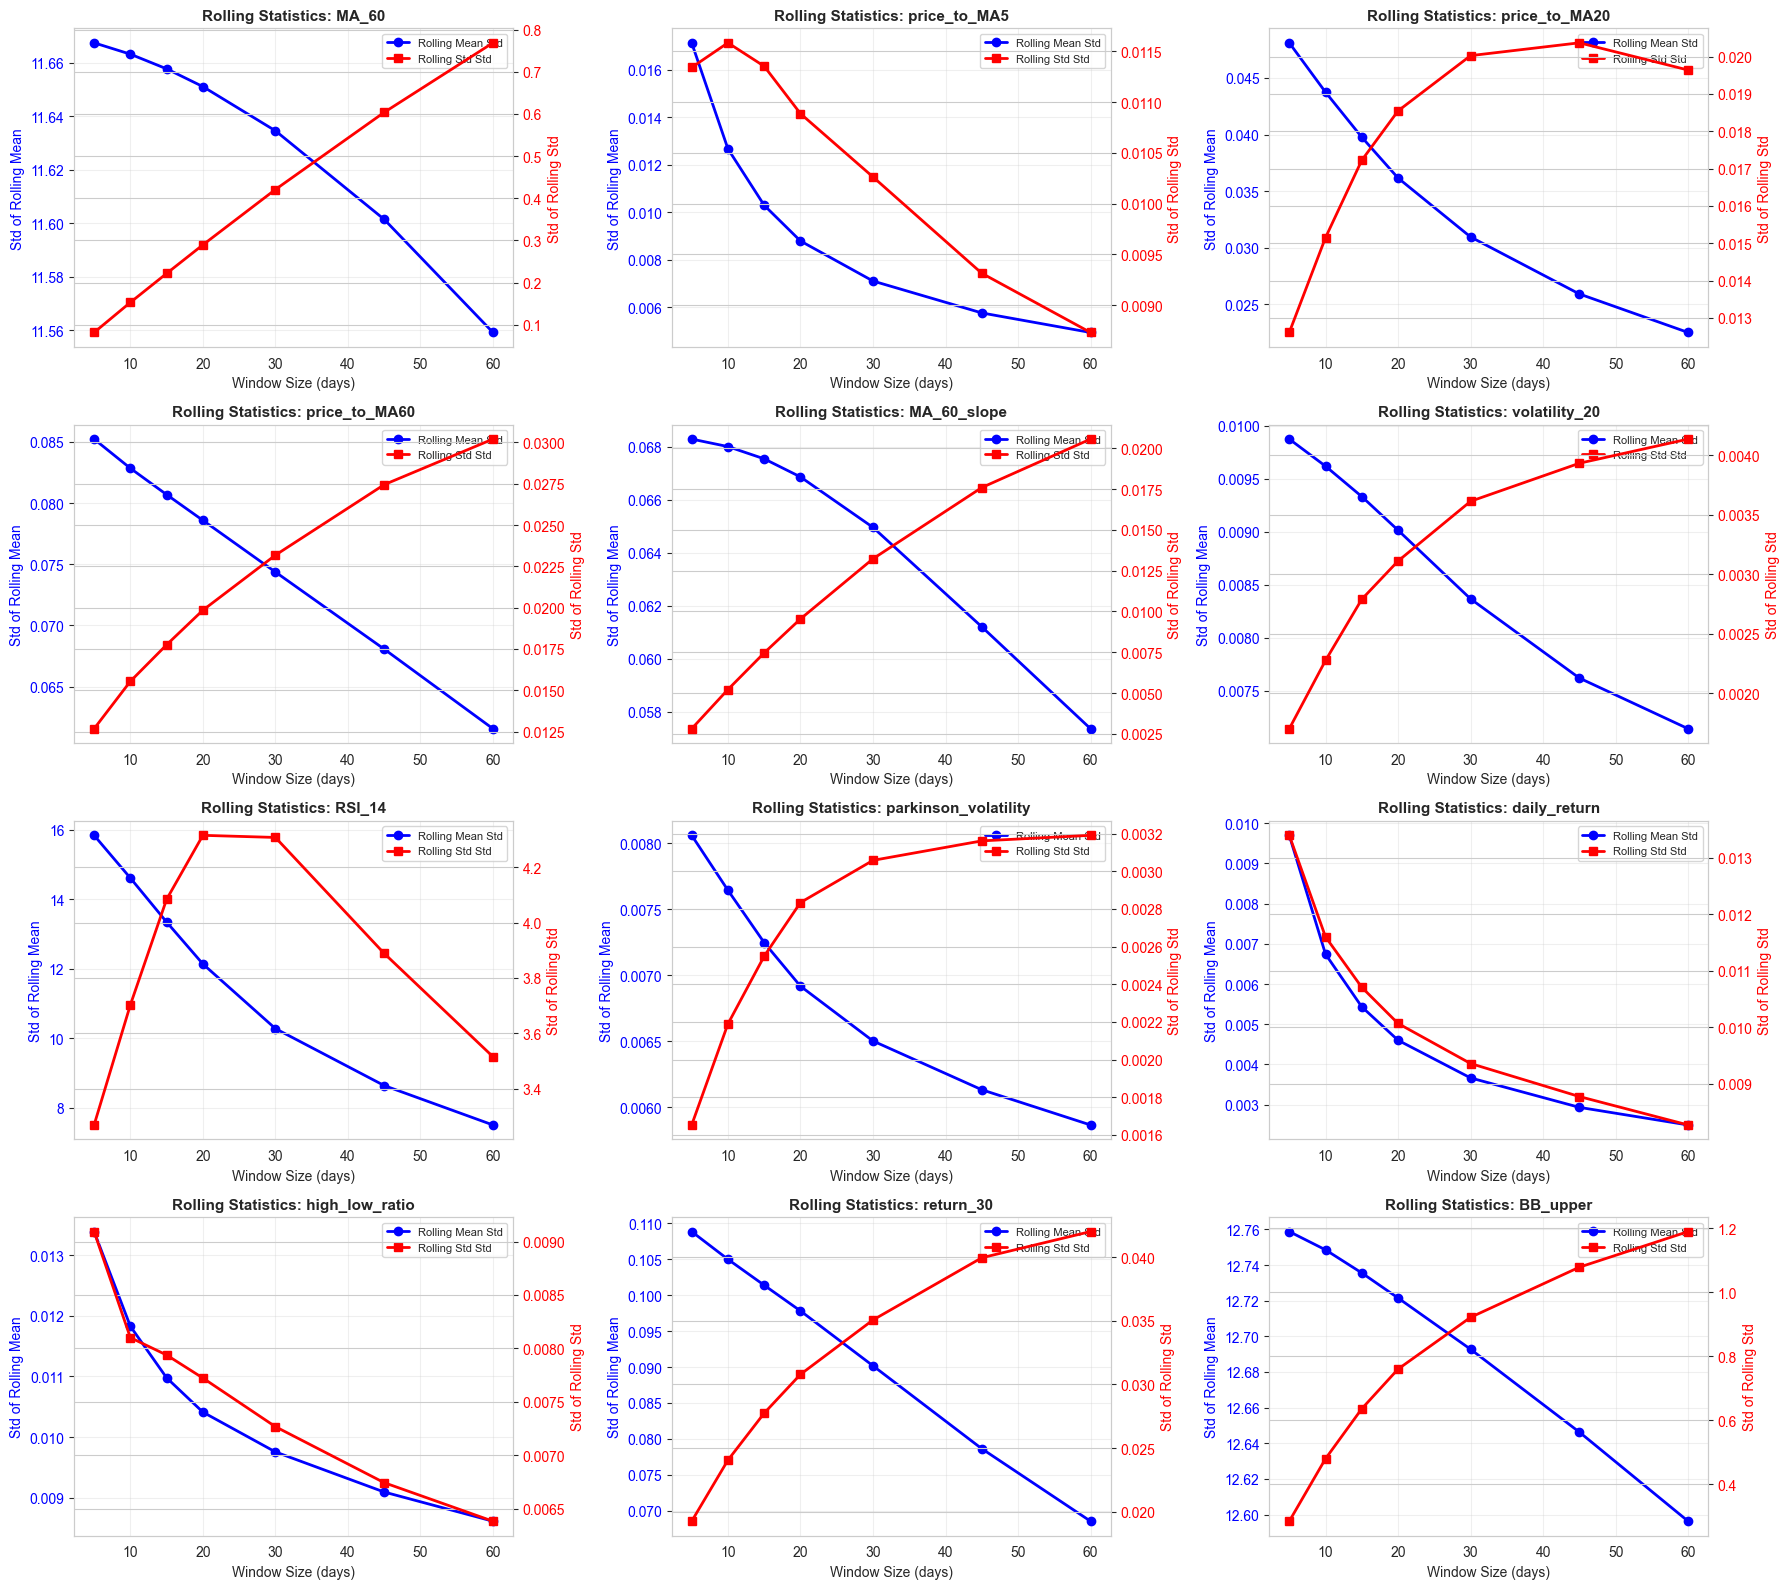


✓ Saved: 06_rolling_statistics_part3.png


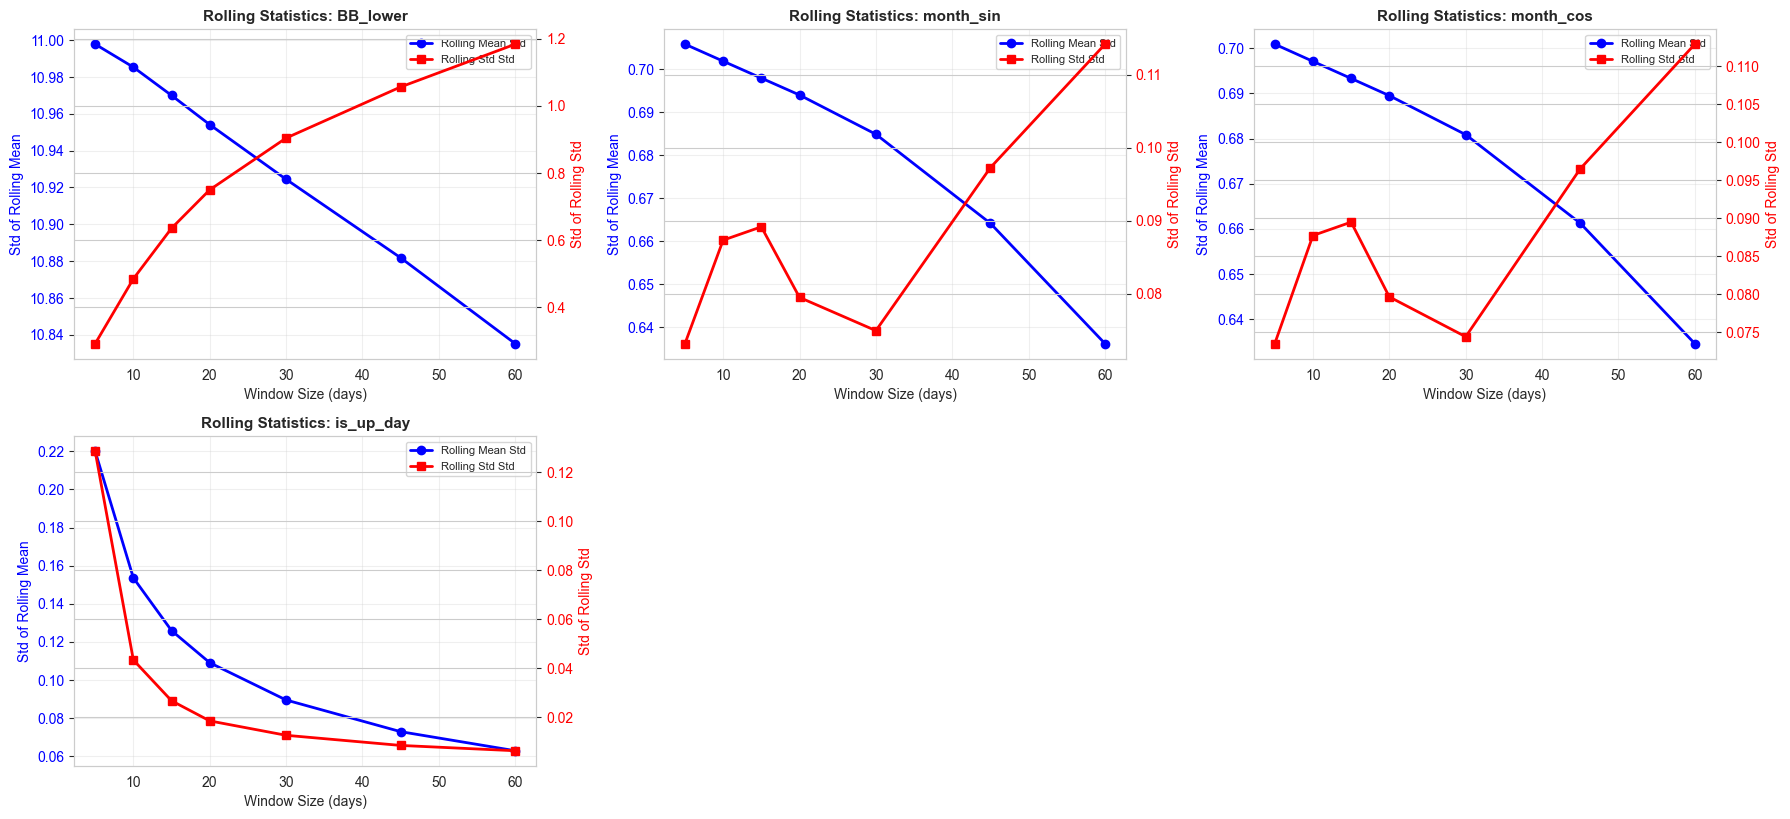


✓ Rolling statistics analysis complete! Created 3 figure(s)

SUMMARY: FEATURE STABILITY ACROSS WINDOWS

Most Stable Features (by Rolling Mean):
              Feature  Avg_Mean_Stability  Avg_Std_Stability  Mean_Stability_Variance  Std_Stability_Variance
         daily_return            0.005081           0.010312                 0.002321                0.001639
downside_deviation_10            0.005778           0.003098                 0.001119                0.000339
 parkinson_volatility            0.006909           0.002662                 0.000741                0.000531
        volatility_20            0.008710           0.003081                 0.000959                0.000825
         price_to_MA5            0.009528           0.010496                 0.003960                0.001024
       high_low_ratio            0.010581           0.007607                 0.001531                0.000839
        price_to_MA20            0.035313           0.017651                 0.008670

In [66]:
# ============================================================================
# SECTION 7: ROLLING STATISTICS ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("[7] ROLLING STATISTICS ANALYSIS")
print("="*80)
print("Analyzing stability of features across different window sizes")

# ----------------------------------------------------------------------------
# CONFIGURATION
# ----------------------------------------------------------------------------
NUM_TICKERS_TO_USE = 50   # <<< CHANGE THIS TO CONTROL HOW MANY TICKERS TO INCLUDE
windows = [5, 10, 15, 20, 30, 45, 60]
PLOTS_PER_FIGURE = 12     # Number of subplots per figure (4x3 grid)

# ----------------------------------------------------------------------------
# PREPARE DATA
# ----------------------------------------------------------------------------
df_features = df_features.sort_values(['ticker', 'date'])
selected_tickers = df_features['ticker'].dropna().unique()[:NUM_TICKERS_TO_USE]
df_sample = df_features.loc[df_features['ticker'].isin(selected_tickers)].copy()

# ----------------------------------------------------------------------------
# CALCULATE ROLLING STATISTICS
# ----------------------------------------------------------------------------
rolling_stats_results = {feature: {'windows': [], 'mean_std': [], 'std_std': []}
                         for feature in feature_columns}

# Calculate how many figures we need
num_features = len(feature_columns)
num_figures = int(np.ceil(num_features / PLOTS_PER_FIGURE))

print(f"\nTotal features: {num_features}")
print(f"Plots per figure: {PLOTS_PER_FIGURE}")
print(f"Number of figures to create: {num_figures}")

for feature_idx, feature in enumerate(feature_columns):
    print(f"Analyzing rolling stats: {feature} ({feature_idx+1}/{num_features})")

    for window in windows:

        per_ticker_mean_std = []
        per_ticker_std_std = []

        for ticker, g in df_sample.groupby('ticker'):
            ticker_data = g.sort_values('date').reset_index(drop=True)
            rolling_mean = ticker_data[feature].rolling(window=window).mean()
            rolling_std = ticker_data[feature].rolling(window=window).std()

            mean_stability = rolling_mean.std()
            std_stability = rolling_std.std()

            per_ticker_mean_std.append(mean_stability)
            per_ticker_std_std.append(std_stability)

        # Aggregate across tickers (median)
        rolling_stats_results[feature]['windows'].append(window)
        rolling_stats_results[feature]['mean_std'].append(np.median(per_ticker_mean_std))
        rolling_stats_results[feature]['std_std'].append(np.median(per_ticker_std_std))

# ----------------------------------------------------------------------------
# PLOT
# ----------------------------------------------------------------------------
# Initialize first figure
fig_idx = 0
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()
plot_idx_in_figure = 0

for feature_idx, feature in enumerate(feature_columns):
    ax = axes[plot_idx_in_figure]

    windows_list = rolling_stats_results[feature]['windows']
    mean_std_list = rolling_stats_results[feature]['mean_std']
    std_std_list = rolling_stats_results[feature]['std_std']

    ax2 = ax.twinx()

    line1 = ax.plot(windows_list, mean_std_list, 'b-o', label='Rolling Mean Std', linewidth=2)
    line2 = ax2.plot(windows_list, std_std_list, 'r-s', label='Rolling Std Std', linewidth=2)

    ax.set_xlabel('Window Size (days)')
    ax.set_ylabel('Std of Rolling Mean', color='b')
    ax2.set_ylabel('Std of Rolling Std', color='r')
    ax.set_title(f'Rolling Statistics: {feature}', fontsize=11, fontweight='bold')
    ax.tick_params(axis='y', labelcolor='b')
    ax2.tick_params(axis='y', labelcolor='r')
    ax.grid(True, alpha=0.3)

    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='upper right', fontsize=8)

    plot_idx_in_figure += 1

    # Check if we need to save current figure and start a new one
    if plot_idx_in_figure == PLOTS_PER_FIGURE or feature_idx == num_features - 1:
        # Hide any unused subplots in the current figure
        for unused_idx in range(plot_idx_in_figure, PLOTS_PER_FIGURE):
            axes[unused_idx].remove()

        plt.tight_layout()
        filename = f'06_rolling_statistics_part{fig_idx+1}.png'
        plt.savefig(os.path.join(IMAGE_DIR, filename), dpi=300, bbox_inches='tight')
        print(f"\n✓ Saved: {filename}")
        plt.show()

        # Start new figure if there are more features to plot
        if feature_idx < num_features - 1:
            fig_idx += 1
            fig, axes = plt.subplots(4, 3, figsize=(18, 16))
            axes = axes.flatten()
            plot_idx_in_figure = 0

print("\n" + "="*80)
print(f"✓ Rolling statistics analysis complete! Created {fig_idx + 1} figure(s)")
print("="*80)

# ============================================================================
# OPTIONAL: SUMMARY ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("SUMMARY: FEATURE STABILITY ACROSS WINDOWS")
print("="*80)

stability_summary = []

for feature in feature_columns:
    mean_std_values = rolling_stats_results[feature]['mean_std']
    std_std_values = rolling_stats_results[feature]['std_std']

    # Calculate stability metrics (lower is more stable)
    avg_mean_stability = np.mean(mean_std_values)
    avg_std_stability = np.mean(std_std_values)

    # Calculate how much stability changes across windows (consistency)
    mean_stability_variance = np.std(mean_std_values)
    std_stability_variance = np.std(std_std_values)

    stability_summary.append({
        'Feature': feature,
        'Avg_Mean_Stability': avg_mean_stability,
        'Avg_Std_Stability': avg_std_stability,
        'Mean_Stability_Variance': mean_stability_variance,
        'Std_Stability_Variance': std_stability_variance
    })

stability_df = pd.DataFrame(stability_summary)
stability_df = stability_df.sort_values('Avg_Mean_Stability')

print("\nMost Stable Features (by Rolling Mean):")
print(stability_df.head(15).to_string(index=False))

print("\n\nLeast Stable Features (by Rolling Mean):")
print(stability_df.tail(10).to_string(index=False))

# Save summary
stability_df.to_csv('rolling_statistics_summary.csv', index=False)
print("\n✓ Saved: rolling_statistics_summary.csv")